# Assignment 2: “Half-bag” #

**On the DL group details**

Sahil Shah: 20194624, sahil.shah.20@ucl.ac.uk

Akshaya Natarajan: 20069959, akshaya.natarajan.20@ucl.ac.uk

Kamiylah Charles: 20092484, kamiylah.charles.20@ucl.ac.uk

Akshay Parmar: 20153279, akshay.parmar.20@ucl.ac.uk

Chanel Sadrettin-Brown, 16050121, chanel.sadrettin-brown.20@ucl.ac.uk

## Assignment 2.1: A multi-class, multi-layer perceptron ##



In [ ]:
'''3.1 A multi-class, multi-layer perceptron (20 points)

Now that we have moved from binary to multi-class classification, it is time to take on the Fashion- 
MNIST dataset in its true form.

To complete this task you are expected to:

1. Implement a multi-class, multi-layer perceptron with cross-entropy loss for the Fashion- MNIST data.

2. Explore model variants with different layer sizes, depths, etc. to find what works well on the validation set 
and describe the process through which you arrive at your final model.

3. Train your final model to convergence on the training set using an optimisation algorithm of your choice.

4. Provide a plot of the loss on the training set and validation set for each epoch of training.

5. Provide the final accuracy on the training, validation, and test set.

6. Analyse the errors of your models by constructing a confusion matrix. Which classes are
easily “confused” by the model? Hypothesise why.'''

'3.1 A multi-class, multi-layer perceptron (20 points)\n\nNow that we have moved from binary to multi-class classification, it is time to take on the Fashion- \nMNIST dataset in its true form.\n\nTo complete this task you are expected to:\n\n1. Implement a multi-class, multi-layer perceptron with cross-entropy loss for the Fashion- MNIST data.\n\n2. Explore model variants with different layer sizes, depths, etc. to find what works well on the validation set \nand describe the process through which you arrive at your final model.\n\n3. Train your final model to convergence on the training set using an optimisation algorithm of your choice.\n\n4. Provide a plot of the loss on the training set and validation set for each epoch of training.\n\n5. Provide the final accuracy on the training, validation, and test set.\n\n6. Analyse the errors of your models by constructing a confusion matrix. Which classes are\neasily “confused” by the model? Hypothesise why.'

In [ ]:
## importing packages ##

import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
def load_data(batch_size = 64):
    ## loading and transforming the data for use in pytorch ##

  
    transform = transforms.ToTensor()
    trainset = datasets.FashionMNIST('Fashion_MNIST', download = True, train = True, transform = transform)
    testset = datasets.FashionMNIST('Fashion_MNIST', download = True, train = False, transform = transform)

    # create an array of all indices in training set (60,000 images) and shuffle them to make split unbiased
    indices = np.arange(60000)
    np.random.shuffle(indices)

    # load the datasets using batch size defined (50,000:10,000 for train:validation), only shuffle the test data
    train_load = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[:50000]))
    validation_load = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[50000:]))
    test_load = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

    return trainset, testset, train_load, validation_load, test_load

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
782
157
157


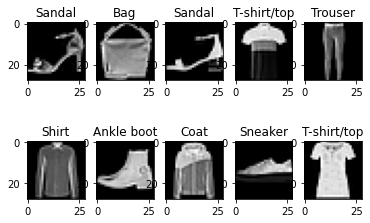

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
# checking data loaded correctly

trainset, testset, train_load, validation_load, test_load = load_data()

# check that the data has been loaded correctly by testing the shape of the train/test sets
train_shape = train_load.dataset.data.shape
print(train_shape)
test_shape = test_load.dataset.data.shape
print(test_shape)

# check that split and batches are working
print(len(train_load))
print(len(validation_load))
print(len(test_load))

data = iter(train_load)
images, labels = data.next()

item_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display some random images in training set

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(item_classes[labels[i].item()])
plt.show()

# checking that the image and label have the right dimension, given the batch size

print(images.shape) 
print(labels.shape)

In [ ]:
## initialise parameters ##

in_size = 784 # input size is flattened vector, 28x28
h_size = 200 # hidden layer size
L = 1 # number of layers
classes = 10 # number of classes

In [ ]:
## create MLP and define forward propagation ##

class MLP(nn.Module):
    def __init__(self, in_size, h_size, classes, L): 
        super(MLP, self).__init__()
        self.hidden_layers = []
        self.L = L
        self.l1 = nn.Linear(in_size, h_size)
        for i in range(self.L):
            self.hidden_layers.append(nn.Linear(h_size, h_size))
        self.l2 = nn.Linear(h_size, classes)
    
    def forward(self, x):
        x = torch.relu(self.l1(x))
        for i in range(self.L):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.l2(x)
        return x

MLP_model = MLP(in_size, h_size, classes, L)

In [ ]:
## loss function and optimizer ##

# using cross entropy loss as specified in question, this will automatically compute softmax at the output layer
# to find the probability of image belonging to each of the 10 classes
loss_func = nn.CrossEntropyLoss()

def optim(learning_rate = 0.001):
    # use the ADAM optimiser
    optimizer = torch.optim.Adam(MLP_model.parameters(), lr=learning_rate)
    return optimizer

In [ ]:
## training the model and testing it on the validation set ##

# iterating over epochs and images, forward pass, calculate loss, backward pass, optimizer step for updates.
# with each epoch the validation set will be run through the model

def train_validate(epochs = 10):
    
    # calling relevant functions
    
    trainset, testset, train_load, validation_load, test_load = load_data()
    optimizer = optim()
   

    
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []
    
    for epoch in range(epochs):
        
        # initialising empty lists to help print and plot progress per epoch
        
        epoch_loss_train= []
        epoch_acc_train = []
        epoch_loss_val = []
        epoch_acc_val = []
        correct_t = 0
        total_t = 0
        correct_v = 0
        total_v = 0

        # training the model
        
        for i, (images, labels) in enumerate(train_load):
            
            MLP_model.train()
        
            images = images.reshape(-1, 784) # flatten image tensor to be a vector of 28x28 features, with batch_size examples (i.e (batch_size, 784))

            # Forward pass
            outputs = MLP_model(images)
            loss_t = loss_func(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            epoch_loss_train.append(loss_t.item()) # appending loss to list

            _, predict = torch.max(outputs.data, 1) # convert output to probability
            total_t += labels.size(0) # total number of classifications made
            correct_t += (predict == labels).sum().item() # number of correct classifications

            epoch_acc_train.append(100.0 * correct_t / total_t) # calculate accuracy for each epoch


        # evaluate trained model on validation set per epoch
        
        for j, (images, labels) in enumerate(validation_load):
            
            MLP_model.eval()
            
            images = images.reshape(-1, 784)
          
            outputs = MLP_model(images)
            loss_v = loss_func(outputs, labels)
            epoch_loss_val.append(loss_v.item())

            _, predict = torch.max(outputs.data, 1)
            total_v += labels.size(0) # total number of samples
            correct_v += (predict == labels).sum().item() # total number of samples classified correctly
            epoch_acc_val.append(100.0 * correct_v / total_v)

            
        loss_train.append(sum(epoch_loss_train)/len(epoch_loss_train)) # loss per epoch train set
        acc_train.append(sum(epoch_acc_train)/len(epoch_acc_train)) # accuracy per epoch train set
        loss_val.append(sum(epoch_loss_val)/len(epoch_loss_val)) # loss per epoch validation set
        acc_val.append(sum(epoch_acc_val)/len(epoch_acc_val)) # loss per epoch validation set
        
        # printing the loss and accuracy for training and validation per epoch
        
        print(f'Epoch: {epoch +1}/{epochs}, Training Loss: {loss_train[epoch]:.4f}, Accuracy:{acc_train[epoch]:.2f}% and Validation Loss:{loss_val[epoch]:.4f}, Accuracy: {acc_val[epoch]:.2f}%')

    
    # plotting loss per epoch for the training and validation sets
    
    plt.figure(figsize=(9,4.8))
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_train, label = 'training set')
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_val, label ='validation set')
    plt.legend()
    plt.title('Loss against epochs for training and validation set')
    plt.xticks(np.arange(1, epochs+1))
    plt.xlabel('Epoch #')
    plt.ylabel('Cross Entropy Loss')
    plt.show()
   
    # plotting accuracy per epoch for the training and validation sets
    
    plt.figure(figsize=(9,4.8))
    plt.plot(np.linspace(1, epochs, epochs).astype(int), acc_train, label = 'training set')
    plt.plot(np.linspace(1, epochs, epochs).astype(int), acc_val, label ='validation set')
    plt.legend()
    plt.title('Accuracy against epochs for training and validation set')
    plt.xticks(np.arange(1, epochs + 1))
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy %')
    plt.show()
    
    # printing final loss and accuracy on training and validation sets
    
    print(f'Final accuracy on training set is {acc_train[-1]:.2f}% and final loss is {loss_train[-1]:.4f}')
    print(f'Final accuracy on validation set is {acc_val[-1]:.2f}% and final loss is {loss_val[-1]:.4f}')
    
    return acc_val

Epoch: 1/10, Training Loss: 0.5811, Accuracy:72.87% and Validation Loss:0.4389, Accuracy: 84.38%
Epoch: 2/10, Training Loss: 0.4022, Accuracy:85.38% and Validation Loss:0.4276, Accuracy: 85.43%
Epoch: 3/10, Training Loss: 0.3646, Accuracy:86.60% and Validation Loss:0.3594, Accuracy: 86.77%
Epoch: 4/10, Training Loss: 0.3376, Accuracy:87.73% and Validation Loss:0.3485, Accuracy: 87.69%
Epoch: 5/10, Training Loss: 0.3180, Accuracy:88.47% and Validation Loss:0.3398, Accuracy: 87.97%
Epoch: 6/10, Training Loss: 0.3042, Accuracy:88.94% and Validation Loss:0.3412, Accuracy: 86.98%
Epoch: 7/10, Training Loss: 0.2890, Accuracy:89.53% and Validation Loss:0.3164, Accuracy: 88.80%
Epoch: 8/10, Training Loss: 0.2801, Accuracy:89.92% and Validation Loss:0.3195, Accuracy: 88.17%
Epoch: 9/10, Training Loss: 0.2680, Accuracy:90.09% and Validation Loss:0.3196, Accuracy: 89.09%
Epoch: 10/10, Training Loss: 0.2620, Accuracy:90.40% and Validation Loss:0.3078, Accuracy: 88.43%


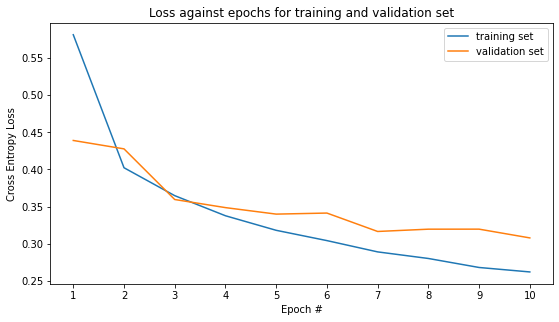

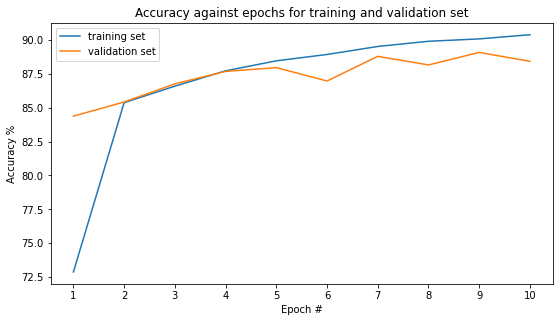

Final accuracy on training set is 90.40% and final loss is 0.2620
Final accuracy on validation set is 88.43% and final loss is 0.3078


[84.38384331750017,
 85.43027863540294,
 86.77068967601475,
 87.68921540474452,
 87.96754828013377,
 86.98138793337439,
 88.8026305151113,
 88.1670419696734,
 89.09277596316493,
 88.4339310485325]

In [ ]:
'''initial model where the following parameters hold:
in_size = 784 # input size is flattened vector, 28x28
h_size = 200 
epochs = 10 
batch_size = 64 
learning_rate = 0.001 '''

train_validate()

In [ ]:
## using the optimal parameter model on test set to classify unseen data and plot the confusion matrix ##

def test():
    trainset, testset, train_load, validation_load, test_load = load_data()
    
    with torch.no_grad():
        MLP_model.eval()
        correct = 0
        total = 0
        prediction = []
        label_all = []

        for images, labels in test_load:
            images = images.reshape(-1, 784)
            labels = labels
            outputs = MLP_model(images)
            loss = loss_func(outputs, labels)

            # max returns (value ,index)
            _, predict = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
            prediction += predict
            label_all += labels
            #print(predict,labels)
        
        confusion = confusion_matrix(label_all,  prediction) # produce confusion matrix
        
        plt.subplots(figsize = (8,6)) # plot heatmap of confusion matrix
        ax = sns.heatmap(confusion, annot=True, fmt = 'g', cmap = 'Blues')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        
        
        #print(classification_report(label_all, prediction)) # produce classification report
       

        acc = 100.0 * correct / total
        print(f'Accuracy on test set: {acc:.2f} %')
        
        print(f'Labels: {item_classes}')
       

number of layers = 2, layer size = 200, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.6464, Accuracy:70.18% and Validation Loss:0.4307, Accuracy: 84.07%
Epoch: 2/30, Training Loss: 0.4207, Accuracy:84.83% and Validation Loss:0.3888, Accuracy: 86.43%
Epoch: 3/30, Training Loss: 0.3802, Accuracy:86.29% and Validation Loss:0.3599, Accuracy: 86.95%
Epoch: 4/30, Training Loss: 0.3530, Accuracy:87.47% and Validation Loss:0.3419, Accuracy: 87.24%
Epoch: 5/30, Training Loss: 0.3362, Accuracy:88.09% and Validation Loss:0.3394, Accuracy: 88.13%
Epoch: 6/30, Training Loss: 0.3225, Accuracy:88.31% and Validation Loss:0.3420, Accuracy: 87.16%
Epoch: 7/30, Training Loss: 0.3115, Accuracy:88.68% and Validation Loss:0.3271, Accuracy: 86.83%
Epoch: 8/30, Training Loss: 0.2980, Accuracy:89.37% and Validation Loss:0.3395, Accuracy: 87.65%
Epoch: 9/30, Training Loss: 0.2896, Accuracy:89.76% and Validation Loss:0.3040, Accuracy: 88.61%
Epoch: 10/30, Training Loss: 0.2817, Accuracy:89.50% and Validat

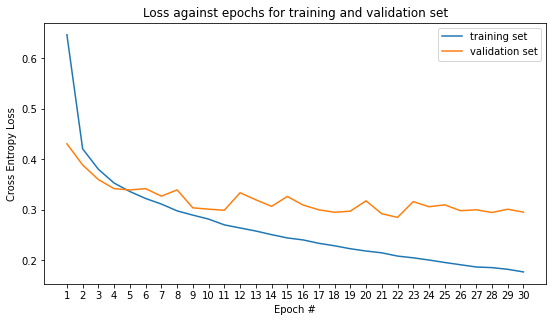

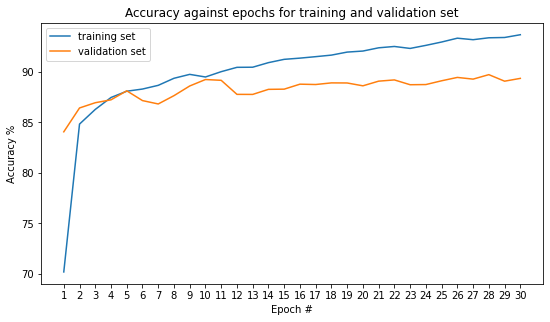

Final accuracy on training set is 93.69% and final loss is 0.1772
Final accuracy on validation set is 89.37% and final loss is 0.2955
Final validation acuracy with current parameters: 89.365830%
number of layers = 2, layer size = 200, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.6564, Accuracy:67.75% and Validation Loss:0.4411, Accuracy: 84.70%
Epoch: 2/30, Training Loss: 0.4202, Accuracy:84.54% and Validation Loss:0.4161, Accuracy: 85.26%
Epoch: 3/30, Training Loss: 0.3809, Accuracy:86.04% and Validation Loss:0.3681, Accuracy: 86.97%
Epoch: 4/30, Training Loss: 0.3542, Accuracy:87.16% and Validation Loss:0.3516, Accuracy: 88.45%
Epoch: 5/30, Training Loss: 0.3354, Accuracy:88.25% and Validation Loss:0.3558, Accuracy: 87.40%
Epoch: 6/30, Training Loss: 0.3185, Accuracy:88.32% and Validation Loss:0.3426, Accuracy: 87.90%
Epoch: 7/30, Training Loss: 0.3072, Accuracy:89.02% and Validation Loss:0.3374, Accuracy: 87.84%
Epoch: 8/30, Training Loss: 0.2970, Accuracy:89.03% and Validati

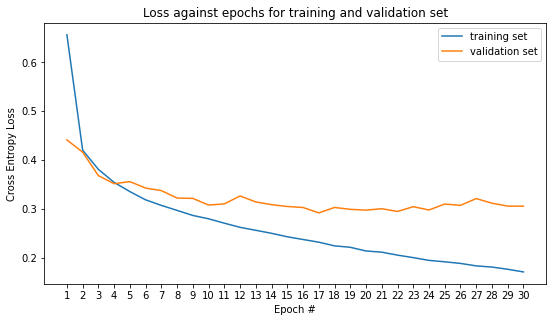

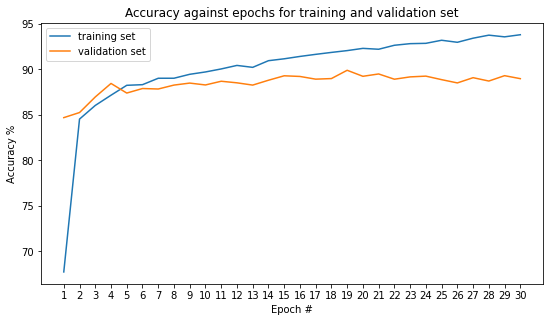

Final accuracy on training set is 93.80% and final loss is 0.1710
Final accuracy on validation set is 88.98% and final loss is 0.3056
Final validation acuracy with current parameters: 88.978870%
number of layers = 2, layer size = 200, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.6419, Accuracy:69.91% and Validation Loss:0.4504, Accuracy: 84.67%
Epoch: 2/30, Training Loss: 0.4170, Accuracy:84.94% and Validation Loss:0.4051, Accuracy: 86.37%
Epoch: 3/30, Training Loss: 0.3775, Accuracy:86.37% and Validation Loss:0.3685, Accuracy: 86.87%
Epoch: 4/30, Training Loss: 0.3513, Accuracy:87.26% and Validation Loss:0.3589, Accuracy: 86.66%
Epoch: 5/30, Training Loss: 0.3322, Accuracy:87.73% and Validation Loss:0.3599, Accuracy: 86.39%
Epoch: 6/30, Training Loss: 0.3183, Accuracy:88.12% and Validation Loss:0.3403, Accuracy: 87.99%
Epoch: 7/30, Training Loss: 0.3055, Accuracy:88.78% and Validation Loss:0.3354, Accuracy: 87.53%
Epoch: 8/30, Training Loss: 0.2951, Accuracy:89.08% and Validatio

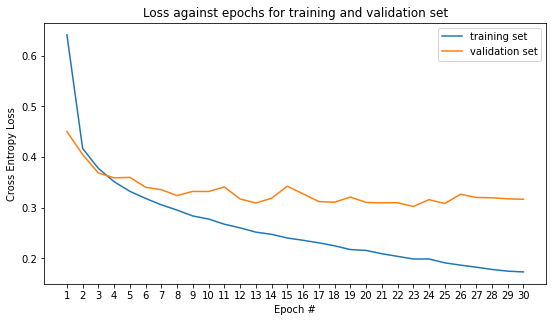

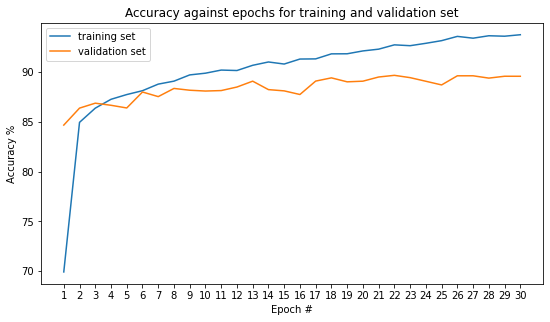

Final accuracy on training set is 93.75% and final loss is 0.1729
Final accuracy on validation set is 89.57% and final loss is 0.3165
Final validation acuracy with current parameters: 89.570858%
number of layers = 2, layer size = 500, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.5830, Accuracy:72.26% and Validation Loss:0.4522, Accuracy: 84.83%
Epoch: 2/30, Training Loss: 0.3969, Accuracy:85.29% and Validation Loss:0.3924, Accuracy: 86.45%
Epoch: 3/30, Training Loss: 0.3570, Accuracy:87.02% and Validation Loss:0.3646, Accuracy: 86.51%
Epoch: 4/30, Training Loss: 0.3306, Accuracy:87.85% and Validation Loss:0.3410, Accuracy: 87.25%
Epoch: 5/30, Training Loss: 0.3107, Accuracy:88.82% and Validation Loss:0.3338, Accuracy: 87.44%
Epoch: 6/30, Training Loss: 0.2948, Accuracy:89.35% and Validation Loss:0.3442, Accuracy: 88.39%
Epoch: 7/30, Training Loss: 0.2813, Accuracy:89.49% and Validation Loss:0.3493, Accuracy: 87.24%
Epoch: 8/30, Training Loss: 0.2728, Accuracy:89.94% and Validat

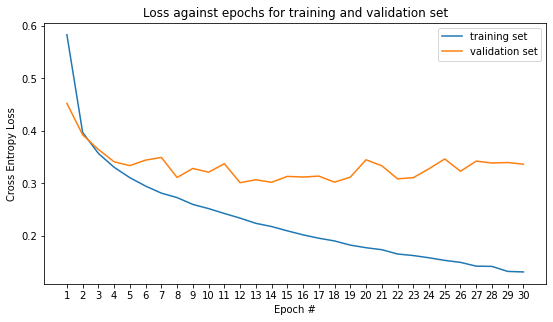

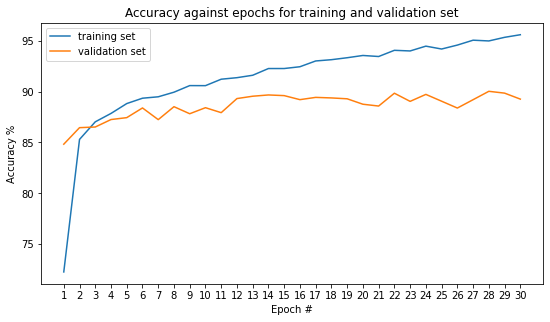

Final accuracy on training set is 95.59% and final loss is 0.1312
Final accuracy on validation set is 89.26% and final loss is 0.3364
Final validation acuracy with current parameters: 89.257844%
number of layers = 2, layer size = 500, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.5807, Accuracy:71.20% and Validation Loss:0.4414, Accuracy: 84.35%
Epoch: 2/30, Training Loss: 0.3947, Accuracy:85.64% and Validation Loss:0.3725, Accuracy: 86.70%
Epoch: 3/30, Training Loss: 0.3529, Accuracy:86.83% and Validation Loss:0.3738, Accuracy: 85.57%
Epoch: 4/30, Training Loss: 0.3288, Accuracy:87.98% and Validation Loss:0.3748, Accuracy: 86.12%
Epoch: 5/30, Training Loss: 0.3102, Accuracy:88.74% and Validation Loss:0.3300, Accuracy: 88.56%
Epoch: 6/30, Training Loss: 0.2938, Accuracy:89.39% and Validation Loss:0.3330, Accuracy: 88.67%
Epoch: 7/30, Training Loss: 0.2800, Accuracy:89.54% and Validation Loss:0.3293, Accuracy: 88.27%
Epoch: 8/30, Training Loss: 0.2699, Accuracy:90.08% and Validati

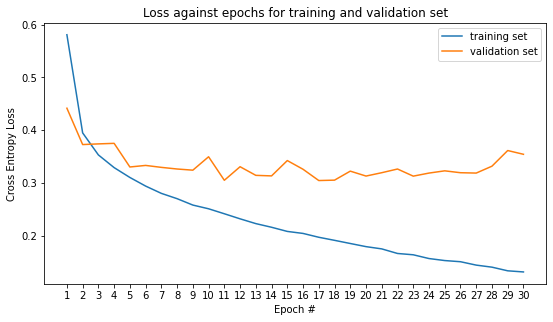

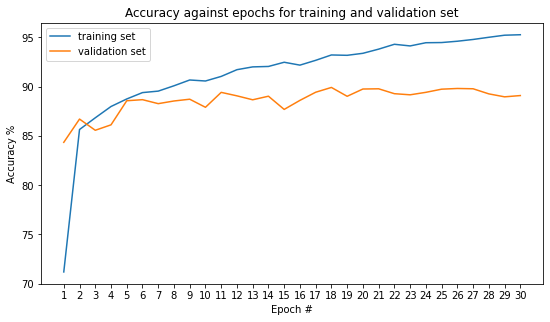

Final accuracy on training set is 95.26% and final loss is 0.1311
Final accuracy on validation set is 89.09% and final loss is 0.3541
Final validation acuracy with current parameters: 89.088217%
number of layers = 2, layer size = 500, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.5857, Accuracy:71.59% and Validation Loss:0.4275, Accuracy: 85.46%
Epoch: 2/30, Training Loss: 0.3963, Accuracy:85.62% and Validation Loss:0.3766, Accuracy: 86.16%
Epoch: 3/30, Training Loss: 0.3565, Accuracy:86.86% and Validation Loss:0.3809, Accuracy: 86.33%
Epoch: 4/30, Training Loss: 0.3288, Accuracy:88.26% and Validation Loss:0.3658, Accuracy: 87.25%
Epoch: 5/30, Training Loss: 0.3104, Accuracy:88.43% and Validation Loss:0.3343, Accuracy: 87.49%
Epoch: 6/30, Training Loss: 0.2941, Accuracy:88.99% and Validation Loss:0.3441, Accuracy: 87.83%
Epoch: 7/30, Training Loss: 0.2811, Accuracy:89.88% and Validation Loss:0.3266, Accuracy: 88.01%
Epoch: 8/30, Training Loss: 0.2691, Accuracy:90.42% and Validatio

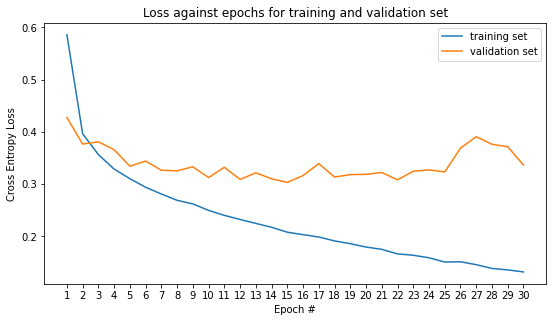

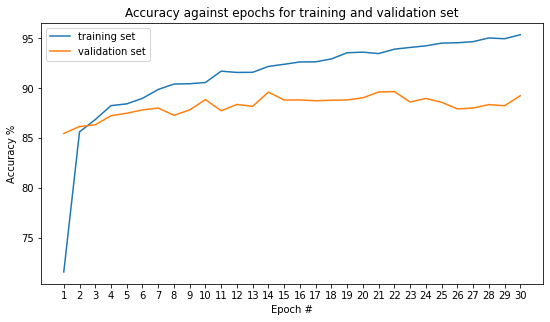

Final accuracy on training set is 95.36% and final loss is 0.1321
Final accuracy on validation set is 89.25% and final loss is 0.3365
Final validation acuracy with current parameters: 89.254675%
number of layers = 2, layer size = 100, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.7093, Accuracy:65.39% and Validation Loss:0.4818, Accuracy: 83.06%
Epoch: 2/30, Training Loss: 0.4396, Accuracy:84.11% and Validation Loss:0.4500, Accuracy: 83.75%
Epoch: 3/30, Training Loss: 0.3993, Accuracy:85.74% and Validation Loss:0.4267, Accuracy: 84.81%
Epoch: 4/30, Training Loss: 0.3770, Accuracy:86.61% and Validation Loss:0.3844, Accuracy: 86.53%
Epoch: 5/30, Training Loss: 0.3594, Accuracy:87.50% and Validation Loss:0.3852, Accuracy: 86.42%
Epoch: 6/30, Training Loss: 0.3475, Accuracy:87.76% and Validation Loss:0.3763, Accuracy: 87.07%
Epoch: 7/30, Training Loss: 0.3346, Accuracy:88.23% and Validation Loss:0.3684, Accuracy: 86.75%
Epoch: 8/30, Training Loss: 0.3247, Accuracy:88.58% and Validat

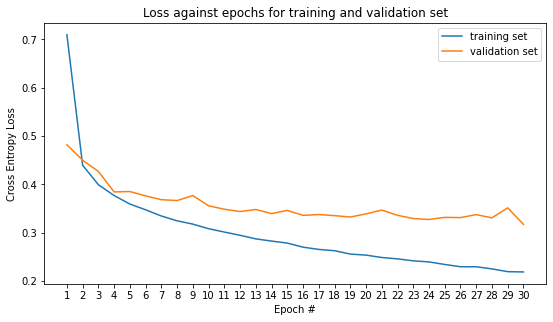

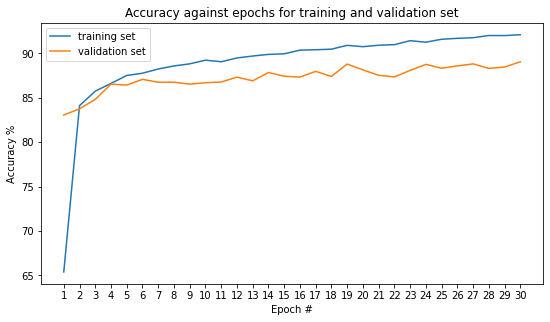

Final accuracy on training set is 92.09% and final loss is 0.2190
Final accuracy on validation set is 89.04% and final loss is 0.3174
Final validation acuracy with current parameters: 89.044715%
number of layers = 2, layer size = 100, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.7036, Accuracy:64.99% and Validation Loss:0.4866, Accuracy: 83.23%
Epoch: 2/30, Training Loss: 0.4395, Accuracy:84.02% and Validation Loss:0.4409, Accuracy: 84.41%
Epoch: 3/30, Training Loss: 0.3981, Accuracy:85.82% and Validation Loss:0.3981, Accuracy: 86.29%
Epoch: 4/30, Training Loss: 0.3733, Accuracy:86.75% and Validation Loss:0.3834, Accuracy: 86.40%
Epoch: 5/30, Training Loss: 0.3560, Accuracy:87.17% and Validation Loss:0.3702, Accuracy: 86.82%
Epoch: 6/30, Training Loss: 0.3450, Accuracy:87.64% and Validation Loss:0.3745, Accuracy: 86.70%
Epoch: 7/30, Training Loss: 0.3320, Accuracy:88.01% and Validation Loss:0.3659, Accuracy: 87.30%
Epoch: 8/30, Training Loss: 0.3238, Accuracy:88.34% and Validati

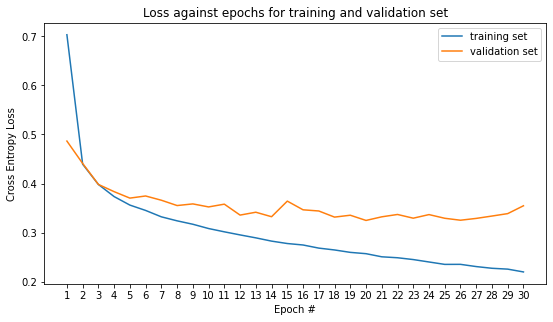

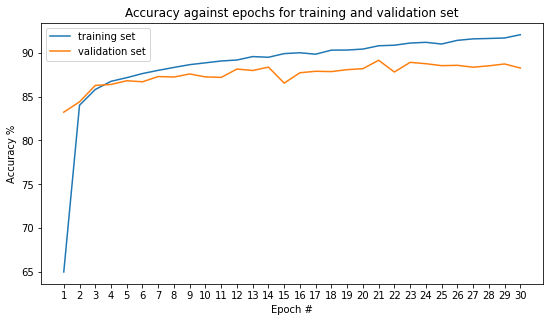

Final accuracy on training set is 92.07% and final loss is 0.2195
Final accuracy on validation set is 88.27% and final loss is 0.3545
Final validation acuracy with current parameters: 88.272923%
number of layers = 2, layer size = 100, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.7039, Accuracy:64.50% and Validation Loss:0.4902, Accuracy: 82.48%
Epoch: 2/30, Training Loss: 0.4409, Accuracy:83.88% and Validation Loss:0.4353, Accuracy: 84.78%
Epoch: 3/30, Training Loss: 0.4004, Accuracy:85.36% and Validation Loss:0.4078, Accuracy: 85.57%
Epoch: 4/30, Training Loss: 0.3744, Accuracy:86.42% and Validation Loss:0.3949, Accuracy: 85.59%
Epoch: 5/30, Training Loss: 0.3593, Accuracy:87.30% and Validation Loss:0.3832, Accuracy: 86.70%
Epoch: 6/30, Training Loss: 0.3434, Accuracy:87.60% and Validation Loss:0.3752, Accuracy: 87.22%
Epoch: 7/30, Training Loss: 0.3317, Accuracy:88.00% and Validation Loss:0.3683, Accuracy: 87.09%
Epoch: 8/30, Training Loss: 0.3209, Accuracy:88.72% and Validatio

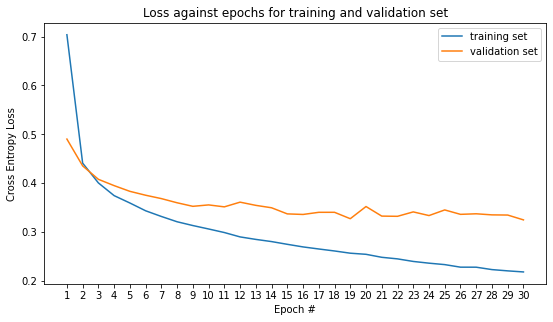

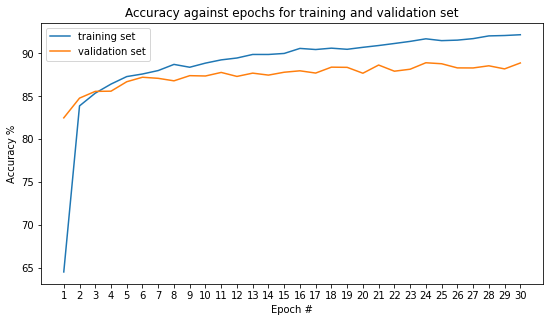

Final accuracy on training set is 92.18% and final loss is 0.2182
Final accuracy on validation set is 88.88% and final loss is 0.3247
Final validation acuracy with current parameters: 88.884584%
number of layers = 3, layer size = 200, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.7504, Accuracy:62.24% and Validation Loss:0.4942, Accuracy: 82.43%
Epoch: 2/30, Training Loss: 0.4442, Accuracy:83.59% and Validation Loss:0.4234, Accuracy: 85.35%
Epoch: 3/30, Training Loss: 0.3997, Accuracy:85.96% and Validation Loss:0.3920, Accuracy: 85.30%
Epoch: 4/30, Training Loss: 0.3751, Accuracy:86.76% and Validation Loss:0.3833, Accuracy: 86.25%
Epoch: 5/30, Training Loss: 0.3562, Accuracy:87.28% and Validation Loss:0.3669, Accuracy: 86.83%
Epoch: 6/30, Training Loss: 0.3431, Accuracy:87.56% and Validation Loss:0.3517, Accuracy: 87.31%
Epoch: 7/30, Training Loss: 0.3305, Accuracy:88.37% and Validation Loss:0.3534, Accuracy: 86.86%
Epoch: 8/30, Training Loss: 0.3206, Accuracy:88.54% and Validat

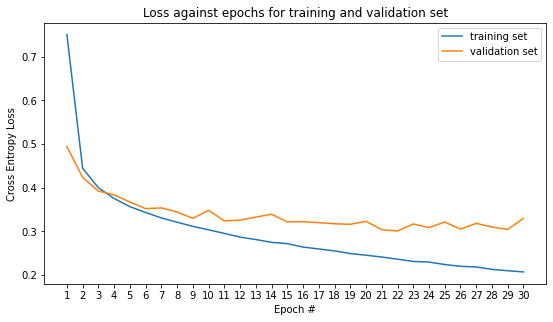

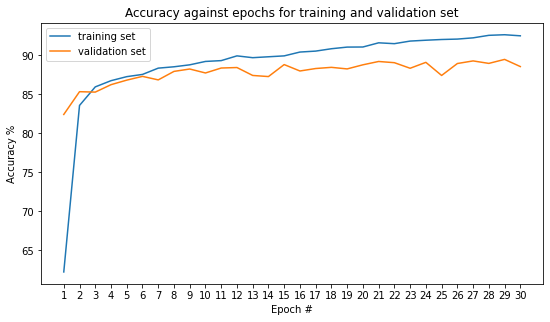

Final accuracy on training set is 92.51% and final loss is 0.2067
Final accuracy on validation set is 88.57% and final loss is 0.3296
Final validation acuracy with current parameters: 88.569685%
number of layers = 3, layer size = 200, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.7330, Accuracy:63.37% and Validation Loss:0.4826, Accuracy: 84.04%
Epoch: 2/30, Training Loss: 0.4393, Accuracy:84.15% and Validation Loss:0.4214, Accuracy: 85.38%
Epoch: 3/30, Training Loss: 0.3917, Accuracy:85.92% and Validation Loss:0.3958, Accuracy: 85.83%
Epoch: 4/30, Training Loss: 0.3685, Accuracy:86.70% and Validation Loss:0.3777, Accuracy: 86.81%
Epoch: 5/30, Training Loss: 0.3499, Accuracy:87.74% and Validation Loss:0.3866, Accuracy: 87.13%
Epoch: 6/30, Training Loss: 0.3356, Accuracy:87.86% and Validation Loss:0.3584, Accuracy: 87.31%
Epoch: 7/30, Training Loss: 0.3240, Accuracy:88.62% and Validation Loss:0.3549, Accuracy: 87.62%
Epoch: 8/30, Training Loss: 0.3127, Accuracy:88.92% and Validati

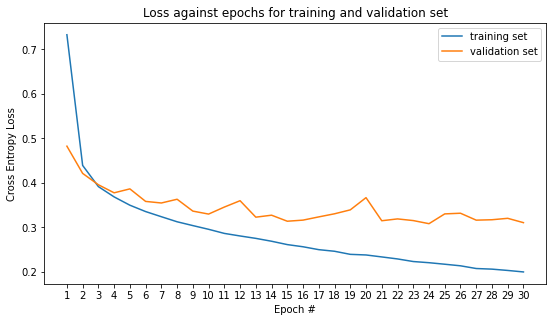

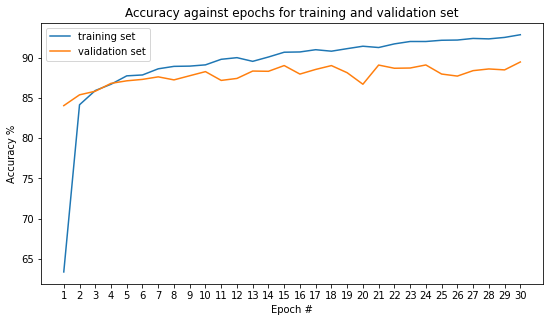

Final accuracy on training set is 92.86% and final loss is 0.1999
Final accuracy on validation set is 89.47% and final loss is 0.3107
Final validation acuracy with current parameters: 89.468712%
number of layers = 3, layer size = 200, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.7189, Accuracy:64.41% and Validation Loss:0.4713, Accuracy: 83.54%
Epoch: 2/30, Training Loss: 0.4352, Accuracy:84.10% and Validation Loss:0.4196, Accuracy: 84.91%
Epoch: 3/30, Training Loss: 0.3914, Accuracy:85.85% and Validation Loss:0.3951, Accuracy: 86.46%
Epoch: 4/30, Training Loss: 0.3666, Accuracy:86.81% and Validation Loss:0.3721, Accuracy: 86.97%
Epoch: 5/30, Training Loss: 0.3469, Accuracy:87.75% and Validation Loss:0.3674, Accuracy: 87.23%
Epoch: 6/30, Training Loss: 0.3342, Accuracy:88.06% and Validation Loss:0.3485, Accuracy: 87.77%
Epoch: 7/30, Training Loss: 0.3215, Accuracy:88.51% and Validation Loss:0.3538, Accuracy: 86.92%
Epoch: 8/30, Training Loss: 0.3122, Accuracy:88.73% and Validatio

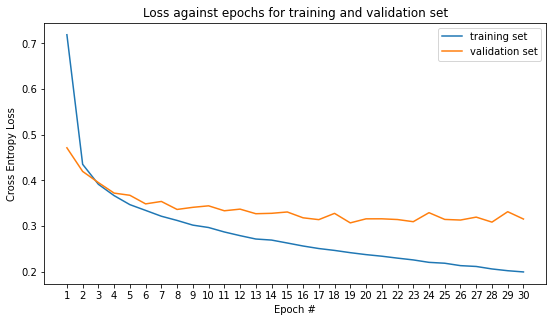

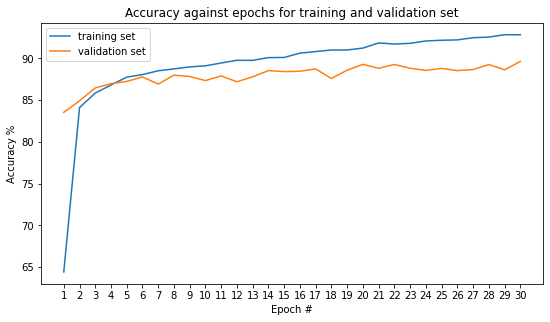

Final accuracy on training set is 92.83% and final loss is 0.1995
Final accuracy on validation set is 89.63% and final loss is 0.3153
Final validation acuracy with current parameters: 89.634162%
number of layers = 3, layer size = 500, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.6452, Accuracy:67.16% and Validation Loss:0.4444, Accuracy: 84.30%
Epoch: 2/30, Training Loss: 0.4111, Accuracy:85.18% and Validation Loss:0.4026, Accuracy: 85.65%
Epoch: 3/30, Training Loss: 0.3697, Accuracy:86.95% and Validation Loss:0.3728, Accuracy: 87.06%
Epoch: 4/30, Training Loss: 0.3451, Accuracy:87.56% and Validation Loss:0.3716, Accuracy: 86.14%
Epoch: 5/30, Training Loss: 0.3294, Accuracy:87.87% and Validation Loss:0.3447, Accuracy: 87.76%
Epoch: 6/30, Training Loss: 0.3159, Accuracy:88.29% and Validation Loss:0.3429, Accuracy: 88.05%
Epoch: 7/30, Training Loss: 0.2996, Accuracy:89.31% and Validation Loss:0.3668, Accuracy: 87.97%
Epoch: 8/30, Training Loss: 0.2901, Accuracy:89.07% and Validat

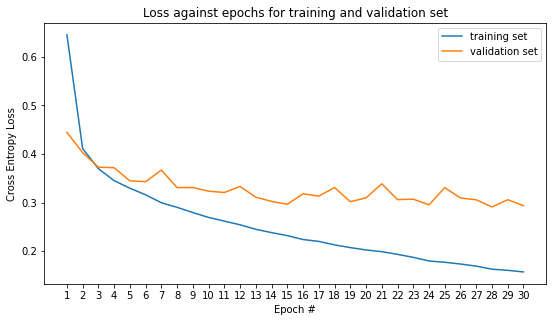

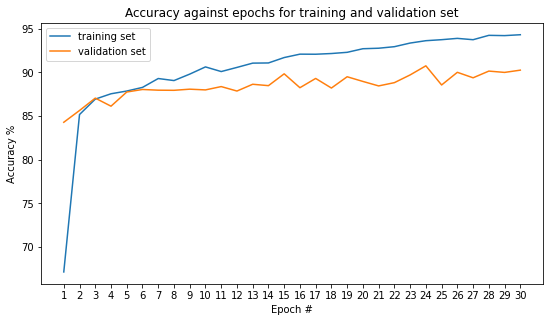

Final accuracy on training set is 94.32% and final loss is 0.1573
Final accuracy on validation set is 90.27% and final loss is 0.2936
Final validation acuracy with current parameters: 90.266987%
number of layers = 3, layer size = 500, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.6404, Accuracy:69.42% and Validation Loss:0.4773, Accuracy: 82.81%
Epoch: 2/30, Training Loss: 0.4105, Accuracy:85.00% and Validation Loss:0.3958, Accuracy: 86.49%
Epoch: 3/30, Training Loss: 0.3675, Accuracy:86.65% and Validation Loss:0.3744, Accuracy: 86.88%
Epoch: 4/30, Training Loss: 0.3462, Accuracy:87.29% and Validation Loss:0.3549, Accuracy: 86.80%
Epoch: 5/30, Training Loss: 0.3243, Accuracy:88.19% and Validation Loss:0.3472, Accuracy: 87.20%
Epoch: 6/30, Training Loss: 0.3083, Accuracy:88.94% and Validation Loss:0.3387, Accuracy: 87.47%
Epoch: 7/30, Training Loss: 0.2949, Accuracy:89.16% and Validation Loss:0.3467, Accuracy: 87.43%
Epoch: 8/30, Training Loss: 0.2843, Accuracy:89.57% and Validati

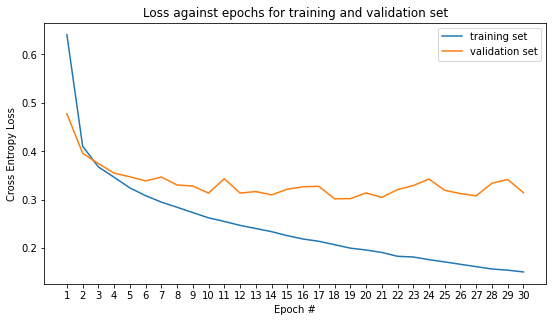

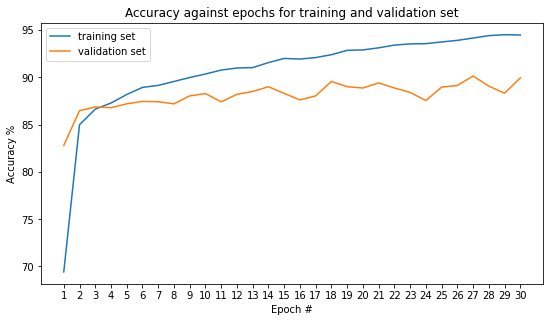

Final accuracy on training set is 94.49% and final loss is 0.1508
Final accuracy on validation set is 89.95% and final loss is 0.3144
Final validation acuracy with current parameters: 89.951705%
number of layers = 3, layer size = 500, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.6441, Accuracy:66.88% and Validation Loss:0.4364, Accuracy: 84.07%
Epoch: 2/30, Training Loss: 0.4106, Accuracy:85.16% and Validation Loss:0.4033, Accuracy: 85.25%
Epoch: 3/30, Training Loss: 0.3706, Accuracy:86.26% and Validation Loss:0.3582, Accuracy: 87.46%
Epoch: 4/30, Training Loss: 0.3437, Accuracy:87.55% and Validation Loss:0.3699, Accuracy: 86.93%
Epoch: 5/30, Training Loss: 0.3247, Accuracy:88.40% and Validation Loss:0.3658, Accuracy: 87.14%
Epoch: 6/30, Training Loss: 0.3104, Accuracy:88.69% and Validation Loss:0.3342, Accuracy: 87.79%
Epoch: 7/30, Training Loss: 0.2966, Accuracy:89.12% and Validation Loss:0.3200, Accuracy: 88.95%
Epoch: 8/30, Training Loss: 0.2883, Accuracy:89.52% and Validatio

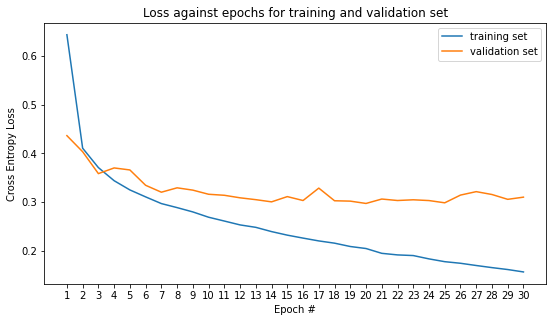

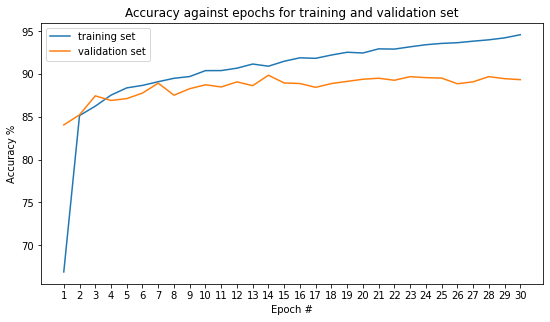

Final accuracy on training set is 94.61% and final loss is 0.1559
Final accuracy on validation set is 89.36% and final loss is 0.3098
Final validation acuracy with current parameters: 89.357258%
number of layers = 3, layer size = 100, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.8402, Accuracy:57.40% and Validation Loss:0.5111, Accuracy: 82.99%
Epoch: 2/30, Training Loss: 0.4804, Accuracy:83.31% and Validation Loss:0.4356, Accuracy: 85.29%
Epoch: 3/30, Training Loss: 0.4263, Accuracy:84.86% and Validation Loss:0.4054, Accuracy: 86.09%
Epoch: 4/30, Training Loss: 0.3984, Accuracy:86.07% and Validation Loss:0.3828, Accuracy: 86.31%
Epoch: 5/30, Training Loss: 0.3797, Accuracy:86.73% and Validation Loss:0.3651, Accuracy: 87.39%
Epoch: 6/30, Training Loss: 0.3647, Accuracy:87.14% and Validation Loss:0.3579, Accuracy: 86.87%
Epoch: 7/30, Training Loss: 0.3526, Accuracy:87.42% and Validation Loss:0.3479, Accuracy: 87.86%
Epoch: 8/30, Training Loss: 0.3446, Accuracy:87.75% and Validat

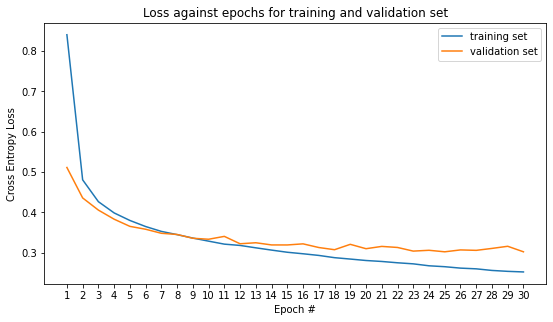

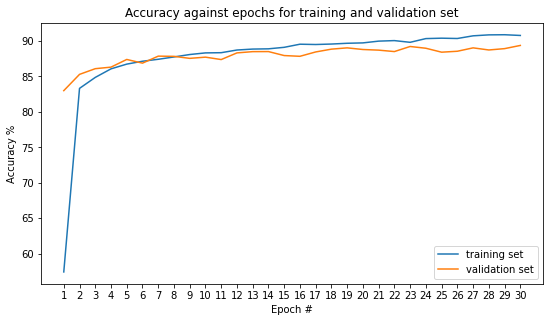

Final accuracy on training set is 90.78% and final loss is 0.2521
Final accuracy on validation set is 89.37% and final loss is 0.3020
Final validation acuracy with current parameters: 89.372145%
number of layers = 3, layer size = 100, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.8198, Accuracy:58.30% and Validation Loss:0.5359, Accuracy: 80.59%
Epoch: 2/30, Training Loss: 0.4753, Accuracy:82.48% and Validation Loss:0.4579, Accuracy: 84.17%
Epoch: 3/30, Training Loss: 0.4251, Accuracy:84.80% and Validation Loss:0.4144, Accuracy: 85.41%
Epoch: 4/30, Training Loss: 0.3985, Accuracy:86.17% and Validation Loss:0.4091, Accuracy: 84.97%
Epoch: 5/30, Training Loss: 0.3800, Accuracy:86.63% and Validation Loss:0.3918, Accuracy: 85.88%
Epoch: 6/30, Training Loss: 0.3655, Accuracy:86.81% and Validation Loss:0.3761, Accuracy: 86.71%
Epoch: 7/30, Training Loss: 0.3555, Accuracy:87.65% and Validation Loss:0.3779, Accuracy: 85.84%
Epoch: 8/30, Training Loss: 0.3439, Accuracy:87.78% and Validati

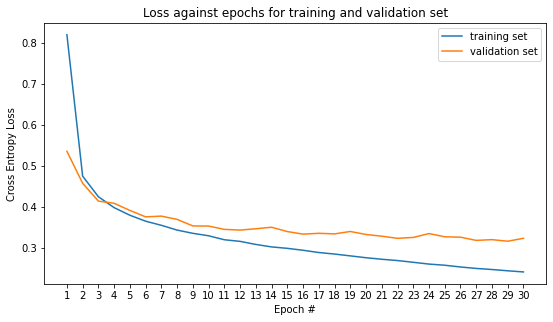

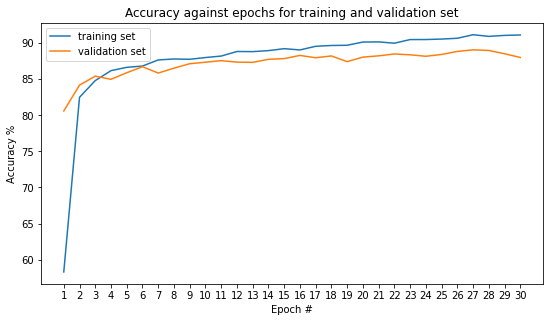

Final accuracy on training set is 91.11% and final loss is 0.2419
Final accuracy on validation set is 88.00% and final loss is 0.3239
Final validation acuracy with current parameters: 87.995605%
number of layers = 3, layer size = 100, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.8188, Accuracy:58.40% and Validation Loss:0.5208, Accuracy: 81.72%
Epoch: 2/30, Training Loss: 0.4663, Accuracy:83.21% and Validation Loss:0.4477, Accuracy: 83.99%
Epoch: 3/30, Training Loss: 0.4128, Accuracy:85.32% and Validation Loss:0.4094, Accuracy: 85.19%
Epoch: 4/30, Training Loss: 0.3864, Accuracy:86.55% and Validation Loss:0.4011, Accuracy: 85.76%
Epoch: 5/30, Training Loss: 0.3669, Accuracy:86.94% and Validation Loss:0.3780, Accuracy: 86.14%
Epoch: 6/30, Training Loss: 0.3551, Accuracy:87.50% and Validation Loss:0.3724, Accuracy: 86.29%
Epoch: 7/30, Training Loss: 0.3444, Accuracy:87.41% and Validation Loss:0.3752, Accuracy: 86.07%
Epoch: 8/30, Training Loss: 0.3345, Accuracy:88.07% and Validatio

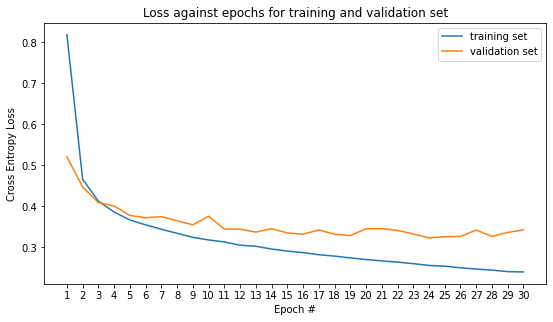

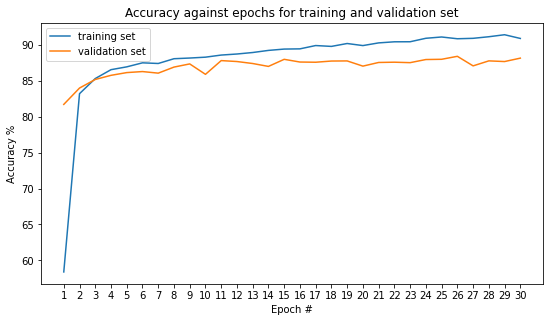

Final accuracy on training set is 90.90% and final loss is 0.2402
Final accuracy on validation set is 88.16% and final loss is 0.3430
Final validation acuracy with current parameters: 88.155923%
number of layers = 4, layer size = 200, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.8597, Accuracy:54.50% and Validation Loss:0.5361, Accuracy: 81.34%
Epoch: 2/30, Training Loss: 0.4801, Accuracy:82.83% and Validation Loss:0.4568, Accuracy: 84.54%
Epoch: 3/30, Training Loss: 0.4234, Accuracy:84.93% and Validation Loss:0.4150, Accuracy: 86.27%
Epoch: 4/30, Training Loss: 0.3955, Accuracy:85.62% and Validation Loss:0.4164, Accuracy: 85.94%
Epoch: 5/30, Training Loss: 0.3765, Accuracy:86.71% and Validation Loss:0.3913, Accuracy: 85.96%
Epoch: 6/30, Training Loss: 0.3622, Accuracy:87.56% and Validation Loss:0.3746, Accuracy: 86.89%
Epoch: 7/30, Training Loss: 0.3506, Accuracy:87.74% and Validation Loss:0.3617, Accuracy: 87.59%
Epoch: 8/30, Training Loss: 0.3399, Accuracy:87.73% and Validat

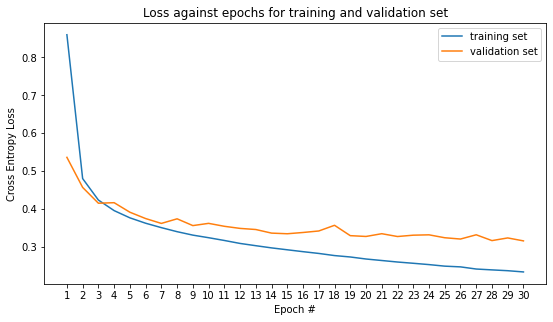

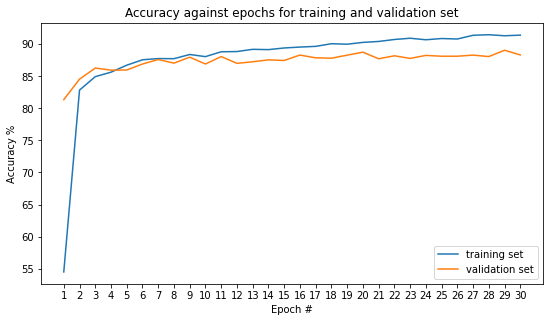

Final accuracy on training set is 91.40% and final loss is 0.2337
Final accuracy on validation set is 88.31% and final loss is 0.3156
Final validation acuracy with current parameters: 88.308773%
number of layers = 4, layer size = 200, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.8382, Accuracy:57.08% and Validation Loss:0.5329, Accuracy: 80.74%
Epoch: 2/30, Training Loss: 0.4694, Accuracy:82.94% and Validation Loss:0.4468, Accuracy: 84.51%
Epoch: 3/30, Training Loss: 0.4170, Accuracy:85.41% and Validation Loss:0.4109, Accuracy: 84.87%
Epoch: 4/30, Training Loss: 0.3876, Accuracy:86.05% and Validation Loss:0.3997, Accuracy: 85.68%
Epoch: 5/30, Training Loss: 0.3689, Accuracy:87.00% and Validation Loss:0.3802, Accuracy: 86.48%
Epoch: 6/30, Training Loss: 0.3544, Accuracy:87.09% and Validation Loss:0.3750, Accuracy: 86.73%
Epoch: 7/30, Training Loss: 0.3434, Accuracy:87.79% and Validation Loss:0.3682, Accuracy: 87.35%
Epoch: 8/30, Training Loss: 0.3319, Accuracy:87.93% and Validati

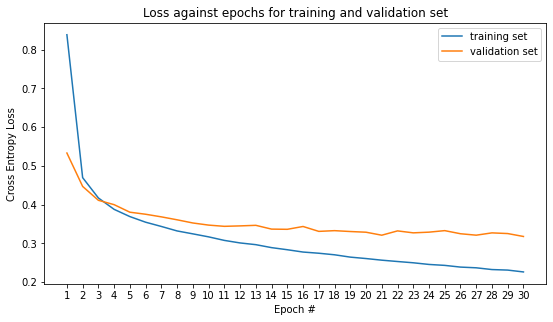

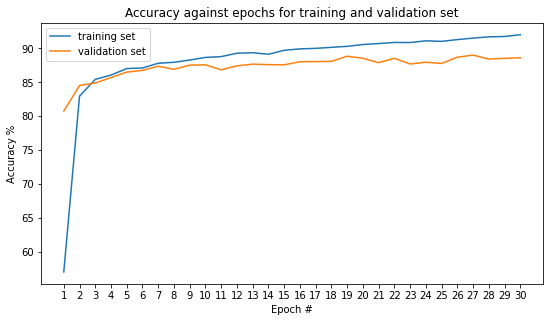

Final accuracy on training set is 91.98% and final loss is 0.2261
Final accuracy on validation set is 88.59% and final loss is 0.3176
Final validation acuracy with current parameters: 88.593134%
number of layers = 4, layer size = 200, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.8411, Accuracy:55.93% and Validation Loss:0.5176, Accuracy: 83.19%
Epoch: 2/30, Training Loss: 0.4702, Accuracy:83.12% and Validation Loss:0.4389, Accuracy: 84.03%
Epoch: 3/30, Training Loss: 0.4167, Accuracy:85.04% and Validation Loss:0.4045, Accuracy: 86.07%
Epoch: 4/30, Training Loss: 0.3891, Accuracy:86.28% and Validation Loss:0.3992, Accuracy: 86.30%
Epoch: 5/30, Training Loss: 0.3693, Accuracy:87.02% and Validation Loss:0.3821, Accuracy: 86.37%
Epoch: 6/30, Training Loss: 0.3556, Accuracy:87.31% and Validation Loss:0.3703, Accuracy: 86.23%
Epoch: 7/30, Training Loss: 0.3432, Accuracy:87.59% and Validation Loss:0.3604, Accuracy: 86.77%
Epoch: 8/30, Training Loss: 0.3317, Accuracy:88.23% and Validatio

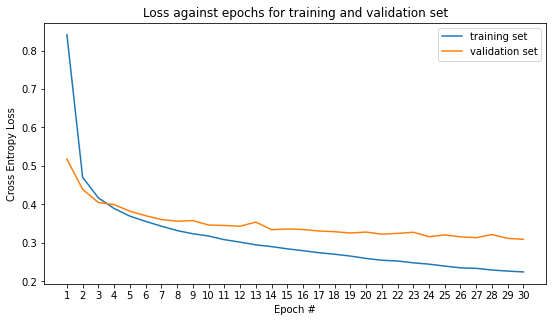

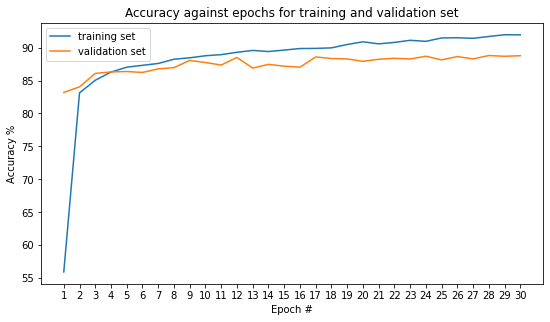

Final accuracy on training set is 91.93% and final loss is 0.2241
Final accuracy on validation set is 88.76% and final loss is 0.3090
Final validation acuracy with current parameters: 88.761120%
number of layers = 4, layer size = 500, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.7313, Accuracy:61.35% and Validation Loss:0.4671, Accuracy: 82.82%
Epoch: 2/30, Training Loss: 0.4349, Accuracy:84.39% and Validation Loss:0.4194, Accuracy: 84.29%
Epoch: 3/30, Training Loss: 0.3912, Accuracy:85.70% and Validation Loss:0.3916, Accuracy: 85.40%
Epoch: 4/30, Training Loss: 0.3632, Accuracy:86.68% and Validation Loss:0.3590, Accuracy: 86.91%
Epoch: 5/30, Training Loss: 0.3463, Accuracy:87.25% and Validation Loss:0.3554, Accuracy: 86.77%
Epoch: 6/30, Training Loss: 0.3297, Accuracy:88.16% and Validation Loss:0.3435, Accuracy: 87.30%
Epoch: 7/30, Training Loss: 0.3186, Accuracy:88.75% and Validation Loss:0.3259, Accuracy: 88.35%
Epoch: 8/30, Training Loss: 0.3086, Accuracy:88.65% and Validat

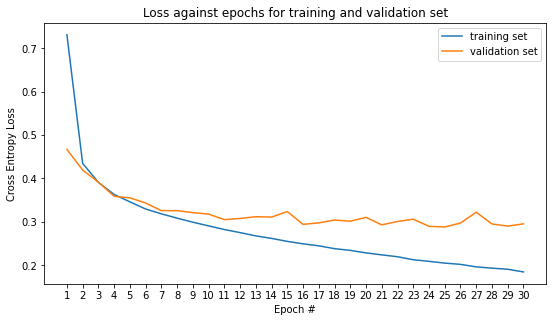

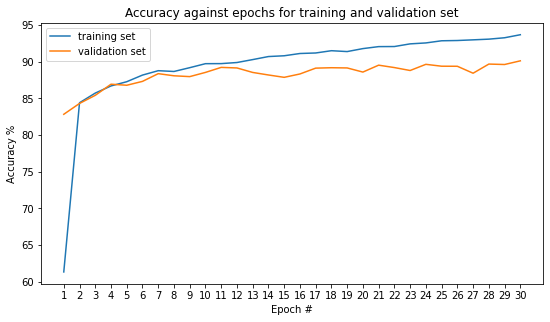

Final accuracy on training set is 93.65% and final loss is 0.1847
Final accuracy on validation set is 90.10% and final loss is 0.2955
Final validation acuracy with current parameters: 90.097072%
number of layers = 4, layer size = 500, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.7168, Accuracy:63.00% and Validation Loss:0.4720, Accuracy: 83.50%
Epoch: 2/30, Training Loss: 0.4269, Accuracy:84.80% and Validation Loss:0.4172, Accuracy: 84.83%
Epoch: 3/30, Training Loss: 0.3846, Accuracy:86.00% and Validation Loss:0.3948, Accuracy: 85.37%
Epoch: 4/30, Training Loss: 0.3603, Accuracy:87.04% and Validation Loss:0.3679, Accuracy: 87.35%
Epoch: 5/30, Training Loss: 0.3420, Accuracy:87.85% and Validation Loss:0.3457, Accuracy: 88.00%
Epoch: 6/30, Training Loss: 0.3258, Accuracy:88.19% and Validation Loss:0.3484, Accuracy: 87.44%
Epoch: 7/30, Training Loss: 0.3155, Accuracy:88.58% and Validation Loss:0.3482, Accuracy: 88.07%
Epoch: 8/30, Training Loss: 0.3043, Accuracy:88.84% and Validati

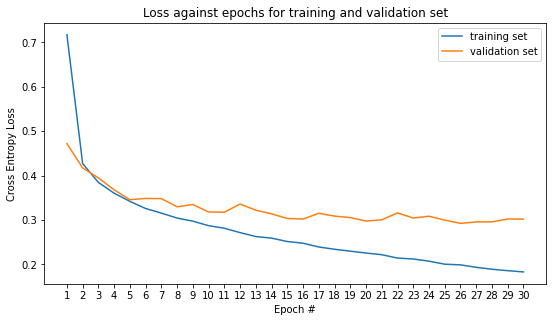

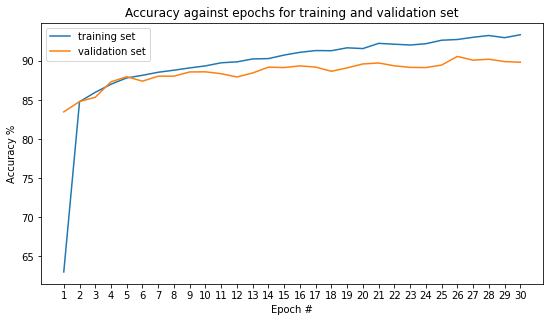

Final accuracy on training set is 93.38% and final loss is 0.1832
Final accuracy on validation set is 89.86% and final loss is 0.3020
Final validation acuracy with current parameters: 89.860547%
number of layers = 4, layer size = 500, learning rate = 0.01
Epoch: 1/30, Training Loss: 0.7383, Accuracy:60.66% and Validation Loss:0.4875, Accuracy: 82.58%
Epoch: 2/30, Training Loss: 0.4299, Accuracy:84.74% and Validation Loss:0.4224, Accuracy: 85.04%
Epoch: 3/30, Training Loss: 0.3828, Accuracy:86.58% and Validation Loss:0.3990, Accuracy: 85.13%
Epoch: 4/30, Training Loss: 0.3574, Accuracy:87.30% and Validation Loss:0.3887, Accuracy: 86.18%
Epoch: 5/30, Training Loss: 0.3394, Accuracy:87.65% and Validation Loss:0.3812, Accuracy: 86.93%
Epoch: 6/30, Training Loss: 0.3254, Accuracy:88.21% and Validation Loss:0.3599, Accuracy: 86.94%
Epoch: 7/30, Training Loss: 0.3119, Accuracy:88.90% and Validation Loss:0.3770, Accuracy: 85.87%
Epoch: 8/30, Training Loss: 0.3019, Accuracy:88.77% and Validatio

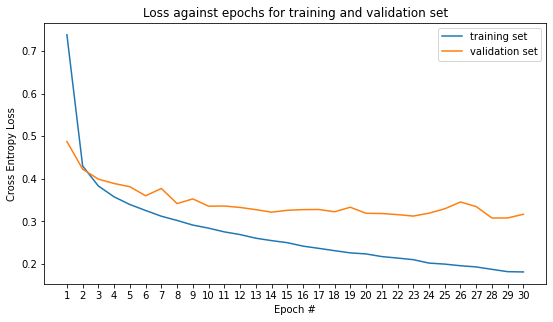

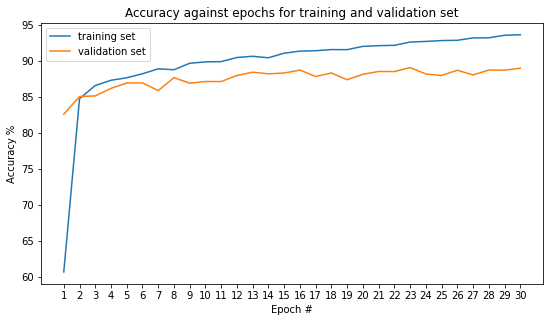

Final accuracy on training set is 93.63% and final loss is 0.1810
Final accuracy on validation set is 88.98% and final loss is 0.3165
Final validation acuracy with current parameters: 88.977868%
number of layers = 4, layer size = 100, learning rate = 0.0001
Epoch: 1/30, Training Loss: 0.9904, Accuracy:50.01% and Validation Loss:0.5923, Accuracy: 80.49%
Epoch: 2/30, Training Loss: 0.5300, Accuracy:81.22% and Validation Loss:0.4721, Accuracy: 83.32%
Epoch: 3/30, Training Loss: 0.4549, Accuracy:84.34% and Validation Loss:0.4248, Accuracy: 85.27%
Epoch: 4/30, Training Loss: 0.4206, Accuracy:85.19% and Validation Loss:0.3953, Accuracy: 86.24%
Epoch: 5/30, Training Loss: 0.3982, Accuracy:86.20% and Validation Loss:0.3775, Accuracy: 87.02%
Epoch: 6/30, Training Loss: 0.3832, Accuracy:86.66% and Validation Loss:0.3786, Accuracy: 86.13%
Epoch: 7/30, Training Loss: 0.3693, Accuracy:86.68% and Validation Loss:0.3590, Accuracy: 87.28%
Epoch: 8/30, Training Loss: 0.3595, Accuracy:87.42% and Validat

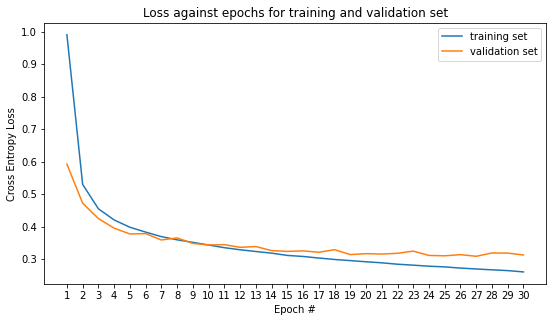

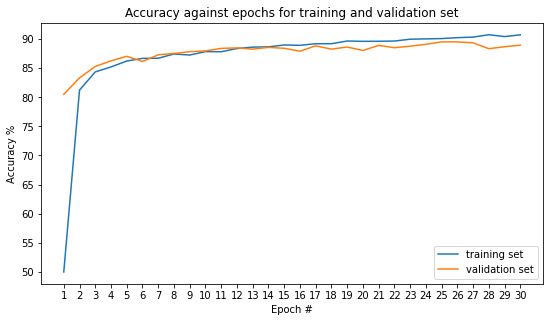

Final accuracy on training set is 90.70% and final loss is 0.2607
Final accuracy on validation set is 88.93% and final loss is 0.3128
Final validation acuracy with current parameters: 88.930475%
number of layers = 4, layer size = 100, learning rate = 0.001
Epoch: 1/30, Training Loss: 0.9647, Accuracy:53.17% and Validation Loss:0.5805, Accuracy: 81.12%
Epoch: 2/30, Training Loss: 0.5282, Accuracy:80.73% and Validation Loss:0.4889, Accuracy: 83.22%
Epoch: 3/30, Training Loss: 0.4635, Accuracy:83.75% and Validation Loss:0.4444, Accuracy: 84.22%
Epoch: 4/30, Training Loss: 0.4271, Accuracy:84.98% and Validation Loss:0.4185, Accuracy: 84.94%
Epoch: 5/30, Training Loss: 0.4047, Accuracy:85.61% and Validation Loss:0.4072, Accuracy: 85.35%
Epoch: 6/30, Training Loss: 0.3890, Accuracy:86.13% and Validation Loss:0.3944, Accuracy: 86.05%
Epoch: 7/30, Training Loss: 0.3758, Accuracy:86.47% and Validation Loss:0.3782, Accuracy: 86.79%
Epoch: 8/30, Training Loss: 0.3653, Accuracy:86.96% and Validati

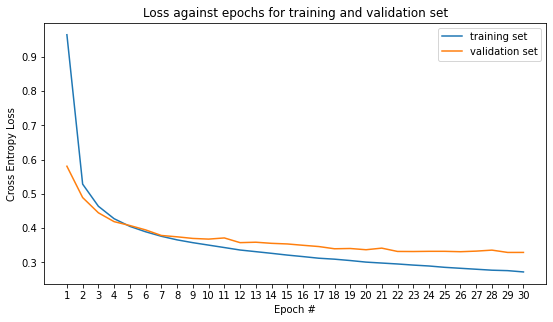

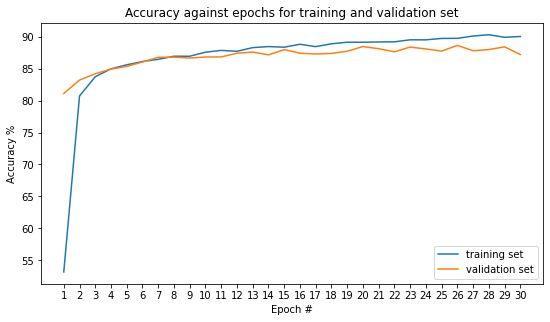

Final accuracy on training set is 90.05% and final loss is 0.2716
Final accuracy on validation set is 87.22% and final loss is 0.3286
Final validation acuracy with current parameters: 87.219588%
number of layers = 4, layer size = 100, learning rate = 0.01
Epoch: 1/30, Training Loss: 1.0023, Accuracy:51.43% and Validation Loss:0.5997, Accuracy: 79.70%
Epoch: 2/30, Training Loss: 0.5365, Accuracy:80.52% and Validation Loss:0.4811, Accuracy: 83.46%
Epoch: 3/30, Training Loss: 0.4627, Accuracy:83.56% and Validation Loss:0.4487, Accuracy: 84.93%
Epoch: 4/30, Training Loss: 0.4271, Accuracy:85.29% and Validation Loss:0.4159, Accuracy: 86.34%
Epoch: 5/30, Training Loss: 0.4051, Accuracy:86.10% and Validation Loss:0.4082, Accuracy: 85.71%
Epoch: 6/30, Training Loss: 0.3894, Accuracy:86.23% and Validation Loss:0.3959, Accuracy: 86.72%
Epoch: 7/30, Training Loss: 0.3774, Accuracy:86.80% and Validation Loss:0.3838, Accuracy: 87.02%
Epoch: 8/30, Training Loss: 0.3663, Accuracy:86.98% and Validatio

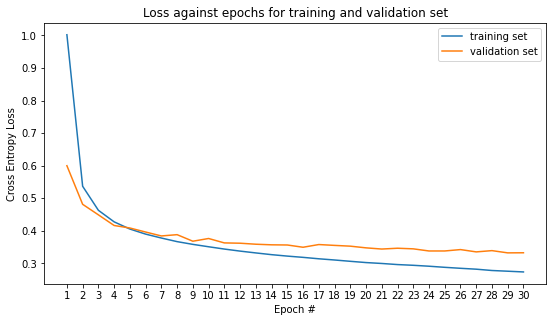

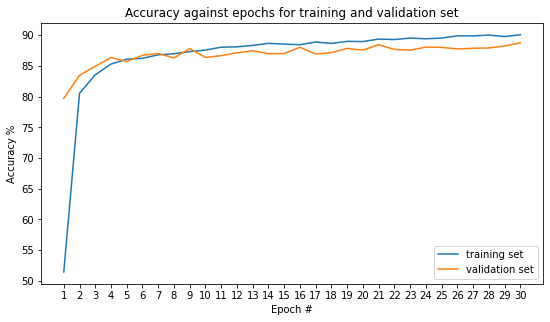

Final accuracy on training set is 90.07% and final loss is 0.2732
Final accuracy on validation set is 88.75% and final loss is 0.3321
Final validation acuracy with current parameters: 88.751384%
The highest validation accuracy 90.2669866264288 was achieved with: batch_size = 64, number_epochs = 30, number_layers = 3 , layer_size = 500, learning_rate = 0.0001


In [ ]:
#Altering: # layers, width of layers and learning_rate

#use two lists one to store final validation accuracy per combination and the other to store that combination of hyper parameters
#loop over the lists of parameters given below
#then use argmax on the final validation accuracy per combination, find out the overall highest val accuracy index
#use the index find the corresponding combination in the other list

#epochs = 30
#batchsize = 64   
layersize = [200, 500, 100]
learningrate = [0.0001, 0.001, 0.01]
numlayers = [2, 3, 4] 


final_validation = [] 
validation_accuracy_v = [] 
for h in numlayers:
    #for i in batchsize:
  for j in layersize:
    for k in learningrate:
    #for l in epoch_list:

      print(f'number of layers = {h}, layer size = {j}, learning rate = {k}')

      load_data(batch_size = 64) # load data with specified batch size
      MLP_model = MLP(in_size, j, classes, h) # set up model and forward prop with specified layer size
      optim(learning_rate = k) # set up optimiser with specified learning rate
      acc_val = train_validate(epochs = 30) # train model with specified epochs

      print(f'Final validation acuracy with current parameters: {acc_val[-1]:2f}%')
      final_validation.append(acc_val[-1]) # store final validation accuracy for current combination

      validation_accuracy_v.append([h,j,k]) # store current combination
                

highest_val_index = np.argmax(final_validation)
highest_val_accuracy = final_validation[highest_val_index]
optimal_params = validation_accuracy_v[highest_val_index]

print(f'The highest validation accuracy {highest_val_accuracy} was achieved with: batch_size = 64, number_epochs = 30, number_layers = {optimal_params[0]} , layer_size = {optimal_params[1]}, learning_rate = {optimal_params[2]}')


Epoch: 1/30, Training Loss: 0.6375, Accuracy:67.89% and Validation Loss:0.4464, Accuracy: 84.63%
Epoch: 2/30, Training Loss: 0.4131, Accuracy:85.01% and Validation Loss:0.3870, Accuracy: 86.27%
Epoch: 3/30, Training Loss: 0.3704, Accuracy:86.60% and Validation Loss:0.3629, Accuracy: 87.32%
Epoch: 4/30, Training Loss: 0.3463, Accuracy:87.51% and Validation Loss:0.3600, Accuracy: 87.27%
Epoch: 5/30, Training Loss: 0.3270, Accuracy:88.12% and Validation Loss:0.3247, Accuracy: 88.69%
Epoch: 6/30, Training Loss: 0.3089, Accuracy:89.12% and Validation Loss:0.3207, Accuracy: 88.69%
Epoch: 7/30, Training Loss: 0.2956, Accuracy:89.15% and Validation Loss:0.3263, Accuracy: 88.52%
Epoch: 8/30, Training Loss: 0.2853, Accuracy:89.42% and Validation Loss:0.3123, Accuracy: 88.78%
Epoch: 9/30, Training Loss: 0.2737, Accuracy:90.21% and Validation Loss:0.3118, Accuracy: 89.19%
Epoch: 10/30, Training Loss: 0.2639, Accuracy:90.34% and Validation Loss:0.3125, Accuracy: 89.12%
Epoch: 11/30, Training Loss: 

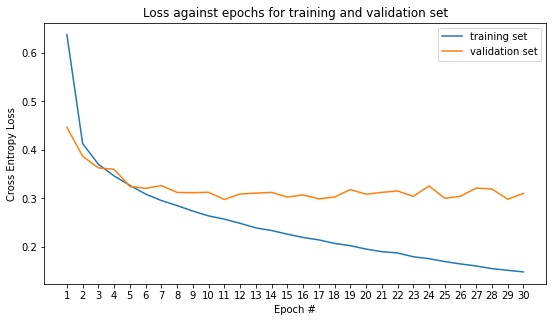

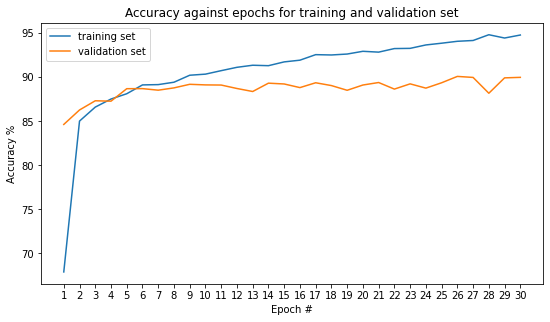

Final accuracy on training set is 94.78% and final loss is 0.1483
Final accuracy on validation set is 89.97% and final loss is 0.3104
Accuracy on test set: 88.97 %
Labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


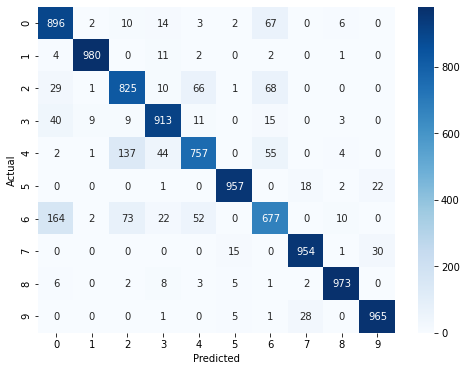

In [ ]:
## training the model on the optimal parameters, applying model to the test set and producing confusion matrix ##

#optimal parameters: batch size = 64, number of epochs = 30, number of layers = 3, layer size = 500 and learning rate = 0.0001

load_data(batch_size = 64) # load data with specified batch size
MLP_model = MLP(in_size, 500, classes, 3) # set up model and forward prop with specified layer size
optim(learning_rate = 0.0001) # set up optimiser with specified learning rate
train_validate(epochs = 30) # train model with specified epochs
test() # use model on the test set



## Assignment 2.2: Denoising autoencoder ##

In [ ]:
!pip install idx2numpy
import idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp36-none-any.whl size=7905 sha256=4baa62eb15c5b4f3b4c6d23fd747d14d37f4663e441fe3a6477c224682344cd3
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
Successfully built idx2numpy


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# importing the training images and splitting it into a training and validation set
train_data = idx2numpy.convert_from_file('train-images-idx3-ubyte')
x_train = train_data[:50000,:]
x_train = x_train.copy()

x_val = train_data[50000:,::]
x_val = x_val.copy()

x_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
x_test = x_test.copy()

In [ ]:
# making the images noisy
t = [0,1]
def noisy(x):
  # remove one or two quadrants of the image
  for _ in t:
    xoffset = np.random.choice([0,14])
    yoffset = np.random.choice([0,14])
    interval1 = range(xoffset, xoffset+14)
    interval2 = range(yoffset, yoffset+14)
    for i in interval1:
      for j in interval2:
        x[i, j] = 0
  
  return x

In [ ]:
x_train_shaped = x_train.reshape(50000,784)

In [ ]:
x_train_noisy = np.zeros((x_train_shaped.shape))
for i in range(x_train_shaped.shape[0]):
  noisied = noisy(x_train_shaped[i,:].T.reshape(28,28))
  x_train_noisy[i, :] = noisied.reshape(784,)

In [ ]:
x_val_shaped = x_val.reshape(10000,784)

In [ ]:
x_val_noisy = np.zeros((x_val_shaped.shape))
for i in range(x_val_shaped.shape[0]):
  noisied = noisy(x_val_shaped[i,:].T.reshape(28,28))
  x_val_noisy[i, :] = noisied.reshape(784,)

In [ ]:
x_test_shaped = x_test.reshape(10000,784)

In [ ]:
x_test_noisy = np.zeros((x_test_shaped.shape))
for i in range(x_test_shaped.shape[0]):
  noisied = noisy(x_test_shaped[i,:].T.reshape(28,28))
  x_test_noisy[i, :] = noisied.reshape(784,)

In [ ]:
# reloading the data so we get the clean images back
train_data = idx2numpy.convert_from_file('train-images-idx3-ubyte')
x_train = train_data[:50000,::]
x_val = train_data[50000:,::]

x_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')

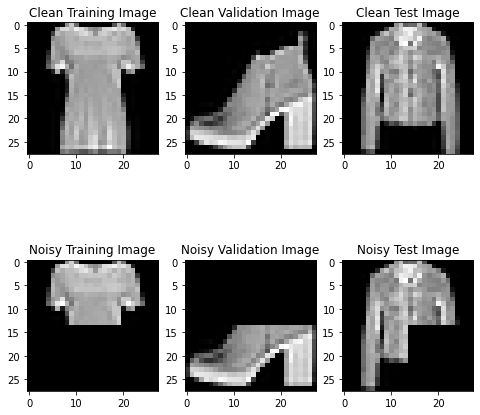

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(2, 3, 1)
plt.imshow(x_train[10,:].reshape(28,28), cmap='gray')
plt.title("Clean Training Image")

plt.subplot(2, 3, 4)
plt.imshow(x_train_noisy[10,:].reshape(28,28), cmap='gray')
plt.title("Noisy Training Image")

plt.subplot(2, 3, 2)
plt.imshow(x_val[10,:].reshape(28,28), cmap='gray')
plt.title("Clean Validation Image")

plt.subplot(2, 3, 5)
plt.imshow(x_val_noisy[10,:].reshape(28,28), cmap='gray')
plt.title("Noisy Validation Image")

plt.subplot(2, 3, 3)
plt.imshow(x_test[10,:].reshape(28,28), cmap='gray')
plt.title("Clean Test Image")

plt.subplot(2, 3, 6)
plt.imshow(x_test_noisy[10,:].reshape(28,28), cmap='gray')
plt.title("Noisy Test Image")

plt.show()
plt.tight_layout()


In [ ]:
# converting the data into tensors
x_train_tensor = torch.tensor(x_train.reshape(50000,28*28), dtype=torch.float)
x_val_tensor = torch.tensor(x_val.reshape(10000,28*28), dtype=torch.float)
x_test_tensor = torch.tensor(x_test.reshape(10000,28*28), dtype=torch.float)

x_train_noisy_tensor = torch.tensor(x_train_noisy.reshape(50000,28*28), dtype=torch.float)
x_val_noisy_tensor = torch.tensor(x_val_noisy.reshape(10000,28*28), dtype=torch.float)
x_test_noisy_tensor = torch.tensor(x_test_noisy.reshape(10000,28*28), dtype=torch.float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  


3.2.1 - Implementing a denoising autoencoder with mean squared error for the Fashion-MNIST data. 

In [ ]:
# putting the noisy and clean training images into one data set

batch_size = 64
trainset = torch.utils.data.TensorDataset(x_train_noisy_tensor, x_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.en1 = nn.Linear(28*28, 256)
    self.en2 = nn.Linear(256,128)
    self.en3 = nn.Linear(128,64)

    self.dec1 = nn.Linear(64,128)
    self.dec2 = nn.Linear(128,256)
    self.dec3 = nn.Linear(256,28*28)

  def forward(self, x):
    x = torch.relu(self.en1(x))
    x = torch.relu(self.en2(x))
    x = torch.relu(self.en3(x))

    x = torch.relu(self.dec1(x))
    x = torch.relu(self.dec2(x))
    x = torch.relu(self.dec3(x))

    return x

In [ ]:
denoised_auto_encoder = AutoEncoder()

In [ ]:
# setting up
learning_rate = 0.01
epochs = 50

# picking cost function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(denoised_auto_encoder.parameters(), lr=learning_rate)

In [ ]:
# training the model:
losses = []
for epoch in range(epochs):
  loss = 0
  for X_prime, X in trainloader:
    # get inputs
    X_prime = X_prime.view(-1, 28*28)
    X_prime = X_prime/255 # normalising the data
    X = X.view(-1,28*28)
    X = X/255

    # set param grads to 0
    optimizer.zero_grad()

    #forward + backward + optimize
    output = denoised_auto_encoder(X_prime)
    train_loss = criterion(output, X)

    train_loss.backward()
    optimizer.step()
    

    loss += train_loss.item()

  loss = loss/(len(trainloader))
  losses.append(loss)
  if epoch%10 == 0:
    print('Epoch: %d/%d,  loss: %.6f'%(epoch + 1,epochs, loss))

Epoch: 1/50,  loss: 0.062457
Epoch: 11/50,  loss: 0.040883
Epoch: 21/50,  loss: 0.039777
Epoch: 31/50,  loss: 0.039510
Epoch: 41/50,  loss: 0.039152


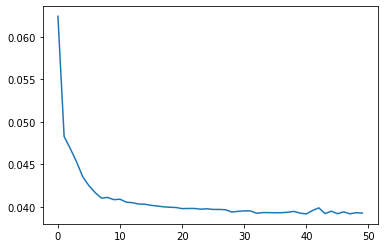

In [ ]:
plt.plot(range(len(losses)), losses)

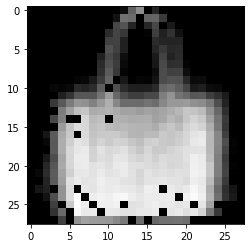

In [ ]:
# seeing the output image against clean image
plt.imshow(output[11].detach().numpy().reshape(28,28), cmap='gray')

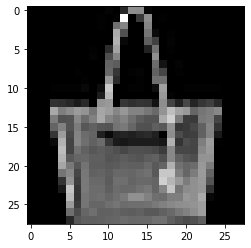

In [ ]:
plt.imshow(X[11].detach().numpy().reshape(28,28), cmap='gray')

3.2.2 - Explore model variants with different layer sizes, depths, etc. to find what works well on the validation set and describe the process through which you arrive at your final model. 

In [ ]:
class AutoEncoderNodesLayers(nn.Module):
  def __init__(self,N,L):
    super().__init__()
    self.N = N
    self.num_layers = L

    self.en1 = nn.Linear(28*28, self.N)

    self.encoder = []
    for i in range(self.num_layers):
      self.encoder.append(nn.Linear(self.N, self.N))

    self.enlast = nn.Linear(self.N, 64)


    self.dec1 = nn.Linear(64, self.N)
    self.decoder = []
    for i in range(self.num_layers):
      self.decoder.append(nn.Linear(self.N, self.N))

    self.declast = nn.Linear(self.N,28*28)
    
  def forward(self, x):
    x = torch.relu(self.en1(x))
    for i in range(self.num_layers):
      x = torch.relu(self.encoder[i](x)) 
    x = torch.relu(self.enlast(x))

    x = torch.relu(self.dec1(x))
    for i in range(self.num_layers):
      x = torch.relu(self.decoder[i](x))
    x = torch.relu(self.declast(x))

    return x

In [ ]:
def training_nodes_lays(nodes, layers, learning):
  model = AutoEncoderNodesLayers(nodes, layers)

  learning_rate = learning
  epochs = 50

  # picking cost function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)


  train_losses = []
  val_losses = []
  for epoch in range(epochs):
    loss = 0
    for X_prime, X in trainloader:
      # get inputs
      X_prime = X_prime.view(-1, 28*28)
      X_prime = X_prime/255
      X = X.view(-1,28*28)
      X = X/255

      # set param grads to 0
      optimizer.zero_grad()

      #forward + backward + optimize
      output = model(X_prime)
      train_loss = criterion(output, X)

      train_loss.backward()
      optimizer.step()
    

      loss += train_loss.item()

    train_loss = loss/(len(trainloader_val))
    train_losses.append(train_loss)

    val_output = model(x_val_noisy_tensor/255)
    val_loss = criterion(val_output, x_val_tensor/255)
    val_losses.append(val_loss)

    if epoch%10 == 0:
      print('Epoch: %d/%d, Train Loss: %.6f, Validation Loss: %.6f'%(epoch + 1,epochs, train_loss, val_loss))
  
  final_val_loss = losses[-1]
  print("Final Validation Loss: ", final_val_loss)
  return final_val_loss

In [ ]:
nodes_range = [64, 128, 256]
layer_range = [1, 3, 5]
learning_range = [0.01, 0.05, 0.001]

In [ ]:
cv = np.zeros((len(nodes_range), len(layer_range), len(learning_range)))

for i in range(len(nodes_range)):
  for j in range(len(layer_range)):
    for k in range(len(learning_range)):
      nodes = nodes_range[i]
      layers = layer_range[j]
      learning = learning_range[k]
        
      print('\n CROSS VALIDATION for number of nodes = %d, number of layers = %d, learning rate = %f'%(nodes, layers, learning))
      final_val_loss = training_nodes_lays(nodes, layers, learning)
      cv[i,j,k] = final_val_loss

In [ ]:
min_ind = cv.argmin()
node_ind, layer_ind, learn_ind = np.unravel_index(min_ind, cv.shape) 
best_num_nodes = nodes_range[node_ind]
best_num_layers = layer_range[layer_ind]
best_learning = learning_range[learn_ind]

print('Lowest validation loss given by number of nodes = %d, number of layers = %d, learning rate = %f'%(best_num_nodes, best_num_layers, best_learning))

3.2.3 - Train your final model to convergence on the training set using an optimisation algorithm of your choice. 

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.en1 = nn.Linear(28*28, 256)
    self.en2 = nn.Linear(256,256)
    self.en3 = nn.Linear(256,64)

    self.dec1 = nn.Linear(64,256)
    self.dec2 = nn.Linear(256,256)
    self.dec3 = nn.Linear(256,28*28)

  def forward(self, x):
    x = torch.relu(self.en1(x))
    x = torch.relu(self.en2(x))
    x = torch.relu(self.en3(x))

    x = torch.relu(self.dec1(x))
    x = torch.relu(self.dec2(x))
    x = torch.relu(self.dec3(x))

    return x

In [ ]:
denoised_auto_encoder = AutoEncoder()

In [ ]:
# setting up
learning_rate = 0.001 
epochs = 50

# picking cost function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(denoised_auto_encoder.parameters(), lr=learning_rate)

In [ ]:
# putting the noisy and clean training images into one data set

batch_size = 64
trainset = torch.utils.data.TensorDataset(x_train_noisy_tensor, x_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
# training the model:
training_loss = []
validation_loss = []

for epoch in range(epochs):
  loss = 0
  for X_prime, X in trainloader:
    # get inputs
    X_prime = X_prime.view(-1, 28*28)
    X_prime = X_prime/255
    X = X.view(-1,28*28)
    X = X/255

    # set param grads to 0
    optimizer.zero_grad()

    #forward + backward + optimize
    output = denoised_auto_encoder(X_prime)
    train_loss = criterion(output, X)

    train_loss.backward()
    optimizer.step()
    

    loss += train_loss.item()

  loss = loss/(len(trainloader))
  training_loss.append(loss)

  val_output = denoised_auto_encoder(x_val_noisy_tensor/255)
  val_loss = criterion(val_output, x_val_tensor/255)
  validation_loss.append(val_loss)

  if epoch%10 == 0:
    print('Epoch: %d/%d,  loss: %.6f, val loss: %.6f'%(epoch + 1,epochs, loss, val_loss))

Epoch: 1/50,  loss: 0.055890, val loss: 0.040757
Epoch: 11/50,  loss: 0.023313, val loss: 0.023841
Epoch: 21/50,  loss: 0.020277, val loss: 0.022308
Epoch: 31/50,  loss: 0.019140, val loss: 0.021148
Epoch: 41/50,  loss: 0.018457, val loss: 0.020713


In [ ]:
print('Final Training Loss: %f \nFinal Validation Loss: %f'%(training_loss[-1],validation_loss[-1]))

Final Training Loss: 0.018175 
Final Validation Loss: 0.020927


3.2.4 - Provide a plot of the loss on the training and validation set for each epoch of training. 

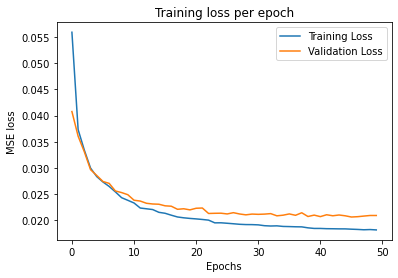

In [ ]:
plt.plot(range(len(training_loss)), training_loss, label="Training Loss")
plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss")
plt.title("Training loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

3.2.5 - Provide a selection of 32 images in their original, "noisy" and "denoised" form from the test set and comment on what the model has been able to learn and what it appears to find challenging. 

In [ ]:
test_output = denoised_auto_encoder(x_test_noisy_tensor)

In [ ]:
indexes = np.random.randint(10000, size=32)

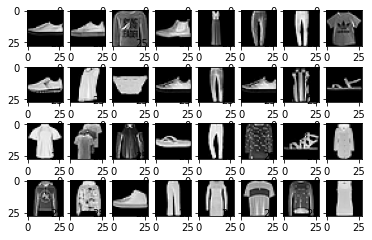

<Figure size 432x288 with 0 Axes>

In [ ]:
# selection of clean test images
for i in range(32):
  j = indexes[i]
  plt.subplot(4, 8, i+1)
  plt.imshow(x_test_tensor[j].detach().numpy().reshape(28,28), cmap='gray')
plt.show()
plt.tight_layout()

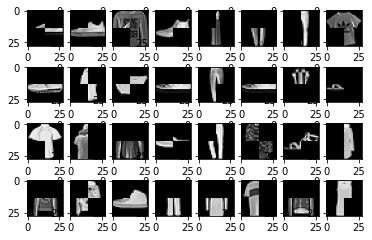

<Figure size 432x288 with 0 Axes>

In [ ]:
# corresponding selection of noisy test images
for i in range(32):
  j = indexes[i]
  plt.subplot(4, 8, i+1)
  plt.imshow(x_test_noisy_tensor[j].detach().numpy().reshape(28,28), cmap='gray')
plt.show()
plt.tight_layout()

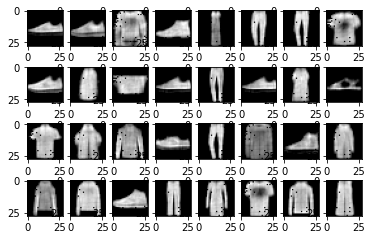

<Figure size 432x288 with 0 Axes>

In [ ]:
# corresponding selection of denoised test images
for i in range(32):
  j = indexes[i]
  plt.subplot(4, 8, i+1)
  plt.imshow(test_output[j].detach().numpy().reshape(28,28), cmap='gray')
plt.show()
plt.tight_layout()

## Assignment 2.3: Sequence prediction ##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
# torch.cuda.is_available() - returns true if avaible or false if not. 
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available to use")
else:
    device = torch.device("cpu")
    print("GPU not available to use, CPU used")

GPU is available to use


In [ ]:
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o ./trainDevTestTrees_PTB.zip # command to download the zip folder 
!unzip -q -o -d ./ ./trainDevTestTrees_PTB.zip
!rm -f ./trainDevTestTrees_PTB.zip

In [ ]:
def loadsst(path):
    xs = []
    ys = []
    with open(path, 'r') as file:
        # Quick, dirty, and improper S-expression parsing.
        for line in file.readlines():
            soup = line.split()  # Split the line into individual words
            # converts first array then l strip it and then convert to integer and then add it to the list.
            ys.append(int(soup[0].lstrip('(')))
            tokens = []
            for chunk in soup[2:]:
                if not chunk.endswith(")"):
                    continue
                tokens.append(chunk.rstrip(')'))
            xs.append(tokens)
    return xs, ys

In [ ]:
ssttrainxs, ssttrainys = loadsst("./trees/train.txt")  # Training data
sstvalidxs, sstvalidys = loadsst("./trees/dev.txt")  # Validation data
ssttestxs, ssttestys = loadsst("./trees/test.txt")  # Testing data

In [ ]:
def scrubData(xs):
    overall = []  # Big list
    for i in range(len(xs)):
        # Making all the sentances in one list where sentance becomes a element broken up by comma's ,
        overall.append(" ".join(xs[i]))
    return overall 

In [ ]:
# sentances we want the model to output when fed with words/ characters
#  added valid and test set
sstraintext = scrubData(ssttrainxs)
ssvalidtext = scrubData(sstvalidxs)
sstesttext = scrubData(ssttestxs)

In [ ]:
# extracts characters from our training data
# join all the words in the sentances together and extract the unique chracters from the combined sentances
#  this is potentially slow, since the runtime of the join function is proportional to the length of sstraintext
charact = set(''.join(sstraintext))

# maps integers to characters via n dictionary
# maps integers to the characters as a dictionary
#  enumerate provides an interface of index and item
integer_to_char = dict(enumerate(charact))
# print(int_to_characters) - maps integers to numbers
# Dictionairy to map characters to integers
# also because of .items calling items from the dictionary.

#  enumerate provides an interface of index and item, so you get c-the character as key, and ind- the index as index
char_to_integer = {c: ind for ind, c in integer_to_char.items()}
# We have 94 characters all in all where 94 characters extracted from the training data and 94rd position not from the training data to account for other possible characters

char_to_integer['others'] = max(char_to_integer.values()) + 1


# Chat_to_integers maps characters to integers.
dictionary_size = len(char_to_integer) # 94 characters possible from characters from training and +1 for other characters mapped to integers



# Sequence length. Can be changed 
maxlength = 80

In [ ]:
def paddingAndClipping(wholeDataset):
    for i in range(len(wholeDataset)):
        if len(wholeDataset[i])<maxlength:
            # padding
            # this method of padding is slow. also, this is right padding to the end, which is bad?
            #while len(overall[i]) < maxlength:
            #    overall[i] += '*'  # padds with a star, but can pad with a space.
            # could just directly pad the string. string manipulation here, |||||| character * (number of character needed to pad) + original sentence = padded sentence e.g. 'a'*10 + 'bcdef' = 'aaaaaaaaaabcdef'
            wholeDataset[i] = '*' * (maxlength-len(wholeDataset[i])) + wholeDataset[i]
        else:
            # clipping
            wholeDataset[i] = wholeDataset[i][:maxlength]
    return wholeDataset


def splittingXY(wholeDataset):
    # Creating lists that will hold our input and target sequences # Many to many process
    input_sequence = []
    target_sequence = []

    for i in range(len(wholeDataset)):
        # removes the last character of the input sequence so it is prepared to predict the last
        input_sequence.append(wholeDataset[i][:-1])
        # all input sequences gets last character removed
        # Removes the first character of the sequence to predict the last
        target_sequence.append(wholeDataset[i][1:])
        # all outputsequenceces gets first character removed.
        # My name is bob and I like ice crea -> input sequence. We do not feed the last character into the model.
        # y name is bob and I like ice cream -> out put sequence. So this will be the correct answer for the model at each time step corresponding to the input sequence
        # So the target sequence will always be one time step ahead of the input sequence
    return input_sequence, target_sequence


#  changed to function
# Converting target sequences of integer instead of characters by mapping them using dictionaires to allow one-hotencoding
def convertXYtoInt(xs, ys):
    for i in range(len(xs)):
        # converting characters in the sequences to sequences of integers by mapping them using dictionaries
        xs[i] = [char_to_integer[character] if character in char_to_integer else (dictionary_size-1)
                            for character in xs[i]]
        # We are using our dictionaries .
        ys[i] = [char_to_integer[character] if character in char_to_integer else (dictionary_size-1)
                            for character in ys[i]]
    return xs, torch.Tensor(ys).to(device)

In [ ]:
# Defining initial hyperparameters for model construction
n_layers = 1 # number of layers
hidden_dim = 150 # hidden state size
n_epochs = 200 #epochs to consider number of times model goes through the entire training dataset
lr = 0.001 # Small learning rate can be adjusted . Rate at which our model updates the weights in the cell each time back propagation is done.
sequence_length = maxlength - 1 # Standardising the length of all the sequences to be equal to the sentances specified -1 as the last character is removed because it will be pedicted 
batch_size = 128 # number of all the sentances in the training is the batch size. This can change to what we put in our model.


In [ ]:
# one hot encoding 
#  the way of setting batch maybe incorrect, removed batch_size
def one_hot_encoding(incoming_sequence, dictionary_size, sequence_length): # input a sequence, it has numbers mapped in dictionary, squeezed to a sequence length and of the whole training batch size 
    # where n_vector represents the features. 3 diensional vector 
    n_vector = np.zeros((len(incoming_sequence), sequence_length, dictionary_size), dtype =np.float32) # creates multi array with a desired outpput shape 
  
    # Replacing the 0 at the relevant character index with a 1 to represent that character.  # going through all the sentances
  
    for i in range(len(incoming_sequence)):
        for j in range(sequence_length):
            n_vector[i, j, incoming_sequence[i][j]] = 1

    return torch.from_numpy(n_vector).to(device)

In [ ]:
# do the preprocessing of all train,test, valid here
print(len(sstraintext))
print(sstraintext[0])
sstraintext = paddingAndClipping(sstraintext)
ssvalidtext = paddingAndClipping(ssvalidtext)
sstesttext  = paddingAndClipping(sstesttext)
print(len(sstraintext))
print(sstraintext[0])

trainxs, trainys = splittingXY(sstraintext)
validxs, validys = splittingXY(ssvalidtext)
testxs, testys   = splittingXY(sstesttext)

trainxs, trainys = convertXYtoInt(trainxs, trainys)
validxs, validys = convertXYtoInt(validxs, validys)
testxs, testys   = convertXYtoInt(testxs, testys)

# Input shape --> (Batch Size, Sequence Length, One-Hot Encoding Size)
# Number of characters is the size of the one hot endcoded vector. 
# input sequence -> (through all sentances, sequence_length, one-hot encoded size) 
# Replaces the corresponding character index with 1. 
trainxs = one_hot_encoding(trainxs, dictionary_size, sequence_length) 
validxs = one_hot_encoding(validxs, dictionary_size, sequence_length) 
testxs = one_hot_encoding(testxs, dictionary_size, sequence_length) 

8544
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
8544
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's go


In [ ]:
print(trainxs.shape)
print(validxs.shape)
print(testxs.shape)
print(len(trainys))
print(len(testys))
print(len(validys))

torch.Size([8544, 79, 94])
torch.Size([1101, 79, 94])
torch.Size([2210, 79, 94])
8544
2210
1101


In [ ]:
# Tensor mode from numpy arrays 
# transfer to device here, also changed to return directly from the functions
#input_sequence = torch.from_numpy(input_sequence).to(device) # Transform numpy arrays to tensor data structure.
#target_sequence = torch.Tensor(target_sequence).to(device) # torch.Tensor is a multidimensional matrix containing elements of a single data type.


In [ ]:
# Use Dataset from pytorch to help batchify training.
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys):
        self.x = xs
        self.y = ys
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)

trainDataset = TorchDataset(trainxs, trainys)
validDataset = TorchDataset(validxs, validys)
testDataset  = TorchDataset(testxs, testys)

# Use Dataloader from pytorch to help batchify training.
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
validDataLoader = torch.utils.data.DataLoader(validDataset, batch_size=len(validDataset), shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testDataset, batch_size=len(testDataset), shuffle=True)


In [ ]:
# Buiding a neuralnetwork model we define classes that inherits PyTorchs base class nn.module
class Model(nn.Module): # defining the class of the model we are consdiering . 
    def __init__(self, input_size, output_size, hidden_dim, n_layers): # all classes in python use innit which is excuted when class is intiated. Function assigns values to object properties are other operations nessary to do when the object is being created
        super(Model, self).__init__() # constructor passing over the varaibles in the classes
        # innit assignes values to the paramters. self paramter is a reference to current instance of the class and is used to access the varaibles that belongs to the class
        # Defining parameters. self used to access the paramters in the class. 
        self.hidden_dim = hidden_dim # refers to hidden size 
        self.n_layers = n_layers # number of layers in the RNN. These parsamters of number of layers and hidden_dim will be passed into the RNN.

        # RNN model used but can consider LSTM, GRU here. 
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first = True) # since batch_first = true then the output tensor is (batch,seq,feature)  
        self.fc = nn.Linear(hidden_dim, output_size) # Weight matrix . No bias is used 
        # using tanh on default setting for non-linearity 

    def forward(self, x):
        
        batch_size = x.size(0) # size of the batch 
        # Intialize hidden state for the first call in the RNN. 
        # removed .cuda, we only need to do that within the function
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden) # passing intialized terms in the hidden state
        out = out.contiguous().view(-1, self.hidden_dim) # this does reshaping of the outputs so it can be fit into a fully connected layer
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        #  changed to to(device) for generalization.
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) # used for first hidden state ofzeros that will be used in the forward pass
        return hidden

In [ ]:
class GRUModel(nn.Module): # defining the class of the model we are consdiering . 
    def __init__(self, input_size, output_size, hidden_dim, n_layers): # all classes in python use innit which is excuted when class is intiated. Function assigns values to object properties are other operations nessary to do when the object is being created
        super(GRUModel, self).__init__() # constructor passing over the varaibles in the classes
        # innit assignes values to the paramters. self paramter is a reference to current instance of the class and is used to access the varaibles that belongs to the class
        # Defining parameters. self used to access the paramters in the class. 
        self.hidden_dim = hidden_dim # refers to hidden size 
        self.n_layers = n_layers # number of layers in the RNN. These parsamters of number of layers and hidden_dim will be passed into the RNN.

        # RNN model used but can consider LSTM, GRU here. 
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first = True) # since batch_first = true then the output tensor is (batch,seq,feature)  
        self.fc = nn.Linear(hidden_dim, output_size) # Weight matrix . No bias is used 
        # using tanh on default setting for non-linearity 

    def forward(self, x):
        
        batch_size = x.size(0) # size of the batch 
        # Intialize hidden state for the first call in the RNN. 
        #  removed .cuda, we only need to do that within the function
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.gru(x, hidden) # passing intialized terms in the hidden state
        out = out.contiguous().view(-1, self.hidden_dim) # this does reshaping of the outputs so it can be fit into a fully connected layer
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        #  changed to to(device) for generalization.
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) # used for first hidden state ofzeros that will be used in the forward pass
        return hidden

In [ ]:
class LSTMModel(nn.Module): # defining the class of the model we are consdiering . 
    def __init__(self, input_size, output_size, hidden_dim, n_layers): # all classes in python use innit which is excuted when class is intiated. Function assigns values to object properties are other operations nessary to do when the object is being created
        super(LSTMModel, self).__init__() # constructor passing over the varaibles in the classes
        # innit assignes values to the paramters. self paramter is a reference to current instance of the class and is used to access the varaibles that belongs to the class
        # Defining parameters. self used to access the paramters in the class. 
        self.hidden_dim = hidden_dim # refers to hidden size 
        self.n_layers = n_layers # number of layers in the RNN. These parsamters of number of layers and hidden_dim will be passed into the RNN.

        # RNN model used but can consider LSTM, GRU here. 
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first = True) # since batch_first = true then the output tensor is (batch,seq,feature)  
        self.fc = nn.Linear(hidden_dim, output_size) # Weight matrix . No bias is used 
        # using tanh on default setting for non-linearity 

    def forward(self, x):
        
        batch_size = x.size(0) # size of the batch 
        # Intialize hidden state for the first call in the RNN. 
        # EDIT: removed .cuda, we only need to do that within the function
        hidden = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        # Passing in the input and hidden + c state into the model and obtaining outputs
        out, (hidden, c) = self.lstm(x, (hidden, c)) # passing intialized terms in the hidden state
        out = out.contiguous().view(-1, self.hidden_dim) # this does reshaping of the outputs so it can be fit into a fully connected layer
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        # EDIT: changed to to(device) for generalization.
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) # used for first hidden state ofzeros that will be used in the forward pass
        return hidden    

In [ ]:
criterion = nn.CrossEntropyLoss() # cross entropy loss is what we want. Measures the peformance of the model 

def optim(lr = 0.001): 
  optimizer = torch.optim.Adam(model.parameters(), lr= lr) # adam is stocastic optimization with also adaptive learning rate. Where as in SGD the learning rate has an equivalent effect for all weights/ paramters 
  return optimizer


In [ ]:
def train_valid(n_epochs = 200):
  
  optimizer = optim() # calling ADAM optimizer
 
  # initialize empty lists to store values for plots
  epoch_num = [] 
  train_l = []
  train_acc = []
  valid_l = []
  valid_acc = []

  # Training Run. hidden - just hidden states into the next cell.
  
  for epoch in range(1, n_epochs + 1): 
      
      # training mode
      model.train()

      train_loss = 0
      train_accuracy = 0

      for batch, (xs, ys) in enumerate(trainDataLoader):
          
          optimizer.zero_grad() # clears the gradient from the preavious epoch.

          output, hidden = model(xs) # so coming in of length maxlength -1 inputs in 
          loss = criterion(output, ys.view(-1).long())
          loss.backward() # Does backpropagation and calculates gradients to help update the weights (and biases if set)
          optimizer.step() # updating the weights in steps 
          
          # log data
          #aggregate batch performance
          train_loss = train_loss + loss.item()
          
          #batch accuracy calculated with only the last element
          train_accuracy = train_accuracy + (torch.max(output.view(-1,sequence_length,dictionary_size)[:,-1,:],1).indices == ys.view(-1,sequence_length)[:,-1]).sum()/batch_size # batch accuracy 
      
      # update initialized lists    
      train_l.append(train_loss/len(trainDataLoader)) 
      train_acc.append(train_accuracy/len(trainDataLoader)*100)

  # Not using full batch but mini batch in training . Full batch is slower in training lower. When hidden paramters are to big it could be equivalent to a full batch 

      #evaluation mode

      model.eval()
      
      valid_loss = 0
      valid_accuracy = 0 
      
      for batch, (xs, ys) in enumerate(validDataLoader):
          
          output, hidden = model(xs) # so coming in of length maxlength -1 inputs in 
          loss = criterion(output, ys.view(-1).long())
         
          #log data
          #aggregate batch performance
          
          valid_loss = valid_loss + loss.item()

          #batch accuracy calculated with only the last element
          
          valid_accuracy = valid_accuracy + (torch.max(output.view(-1,sequence_length,dictionary_size)[:,-1,:],1).indices == ys.view(-1,sequence_length)[:,-1]).sum()/len(xs) # we use full batch in validation set 
          
      # update initialized lists    
      epoch_num.append(epoch)
      valid_l.append(valid_loss/len(validDataLoader))
      valid_acc.append(valid_accuracy/len(validDataLoader)*100)
  
      # print summary for each epoch
      print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
      print("Loss: {:.3f}".format(train_loss/len(trainDataLoader)), end=' ')
      print("Accuracy: {:.3f}".format(train_accuracy/len(trainDataLoader)), end=' ')

      print("ValLoss: {:.3f}".format(valid_loss/len(validDataLoader)), end=' ')
      print("ValAccuracy: {:.3f}".format(valid_accuracy/len(validDataLoader)))

  return valid_accuracy, train_l, train_acc, valid_l, valid_acc, epoch_num


In [ ]:
# grid search for RNN model

hiddendim = [100, 150, 200]
learningrate = [0.001, 0.005, 0.01]
numlayers = [1, 2, 3]  


final_validation = [] 
validation_accuracy_v = [] 

for l in numlayers:
  for h in hiddendim:
    for k in learningrate: 

      print(f'number of layers = {l}, hidden dimension = {h}, learning rate = {k}')

      model = Model(input_size = dictionary_size, output_size = dictionary_size, hidden_dim= h, n_layers=l).to(device) # set up model and forward prop with specified layer size
      optim(lr = k) # set up optimiser with specified learning rate
      valid_accuracy, train_l, train_acc, valid_l, valid_acc, epoch_num = train_valid() # train model with specified epochs

      print(f'Final validation acuracy with current parameters: {valid_accuracy:2f}') # acc_valid[-1] list of validation accuracies from 
      final_validation.append(valid_accuracy) # store final validation accuracy for current combination # acc_valid[-1]

      validation_accuracy_v.append([l,h,k]) # store current combination
                

highest_val_index = np.argmax(final_validation)
highest_val_accuracy = final_validation[highest_val_index]
optimal_params = validation_accuracy_v[highest_val_index]

print(f'The highest validation accuracy {highest_val_accuracy} on the RNN was achieved with: number_epochs = 200, number_layers = {optimal_params[0]} , hidden_dim = {optimal_params[1]}, learning_rate = {optimal_params[2]}')

Streaming output truncated to the last 5000 lines.
Epoch: 51/200............. Loss: 1.578 Accuracy: 0.321 ValLoss: 1.608 ValAccuracy: 0.324
Epoch: 52/200............. Loss: 1.574 Accuracy: 0.323 ValLoss: 1.605 ValAccuracy: 0.320
Epoch: 53/200............. Loss: 1.571 Accuracy: 0.322 ValLoss: 1.601 ValAccuracy: 0.322
Epoch: 54/200............. Loss: 1.567 Accuracy: 0.324 ValLoss: 1.597 ValAccuracy: 0.322
Epoch: 55/200............. Loss: 1.563 Accuracy: 0.324 ValLoss: 1.594 ValAccuracy: 0.328
Epoch: 56/200............. Loss: 1.560 Accuracy: 0.323 ValLoss: 1.591 ValAccuracy: 0.328
Epoch: 57/200............. Loss: 1.556 Accuracy: 0.325 ValLoss: 1.588 ValAccuracy: 0.329
Epoch: 58/200............. Loss: 1.553 Accuracy: 0.327 ValLoss: 1.585 ValAccuracy: 0.330
Epoch: 59/200............. Loss: 1.550 Accuracy: 0.327 ValLoss: 1.582 ValAccuracy: 0.332
Epoch: 60/200............. Loss: 1.547 Accuracy: 0.326 ValLoss: 1.578 ValAccuracy: 0.331
Epoch: 61/200............. Loss: 1.544 Accuracy: 0.328 ValL

In [ ]:
# grid search for GRU

hiddendim = [100, 150, 200]
learningrate = [0.001, 0.005, 0.01]
numlayers = [1, 2, 3]  


final_validation = [] 
validation_accuracy_v = [] 

for l in numlayers:
  for h in hiddendim:
    for k in learningrate: 

      print(f'number of layers = {l}, hidden dimension = {h}, learning rate = {k}')

      model = GRUModel(input_size = dictionary_size, output_size = dictionary_size, hidden_dim= h, n_layers=l).to(device) # set up model and forward prop with specified layer size
      optim(lr = k) # set up optimiser with specified learning rate
      valid_accuracy, train_l, train_acc, valid_l, valid_acc, epoch_num = train_valid() # train model with specified epochs

      print(f'Final validation acuracy with current parameters: {valid_accuracy:2f}') # acc_valid[-1] list of validation accuracies from 
      final_validation.append(valid_accuracy) # store final validation accuracy for current combination # acc_valid[-1]

      validation_accuracy_v.append([l,h,k]) # store current combination
                

highest_val_index = np.argmax(final_validation)
highest_val_accuracy = final_validation[highest_val_index]
optimal_params = validation_accuracy_v[highest_val_index]

print(f'The highest validation accuracy {highest_val_accuracy} on the GRU was achieved with: number_epochs = 200, number_layers = {optimal_params[0]} , hidden_dim = {optimal_params[1]}, learning_rate = {optimal_params[2]}')

Streaming output truncated to the last 5000 lines.
Epoch: 51/200............. Loss: 1.445 Accuracy: 0.520 ValLoss: 1.490 ValAccuracy: 0.522
Epoch: 52/200............. Loss: 1.439 Accuracy: 0.533 ValLoss: 1.490 ValAccuracy: 0.529
Epoch: 53/200............. Loss: 1.435 Accuracy: 0.544 ValLoss: 1.486 ValAccuracy: 0.541
Epoch: 54/200............. Loss: 1.430 Accuracy: 0.546 ValLoss: 1.482 ValAccuracy: 0.569
Epoch: 55/200............. Loss: 1.426 Accuracy: 0.558 ValLoss: 1.478 ValAccuracy: 0.574
Epoch: 56/200............. Loss: 1.421 Accuracy: 0.558 ValLoss: 1.475 ValAccuracy: 0.577
Epoch: 57/200............. Loss: 1.418 Accuracy: 0.561 ValLoss: 1.472 ValAccuracy: 0.554
Epoch: 58/200............. Loss: 1.413 Accuracy: 0.565 ValLoss: 1.469 ValAccuracy: 0.585
Epoch: 59/200............. Loss: 1.410 Accuracy: 0.568 ValLoss: 1.466 ValAccuracy: 0.573
Epoch: 60/200............. Loss: 1.406 Accuracy: 0.571 ValLoss: 1.463 ValAccuracy: 0.604
Epoch: 61/200............. Loss: 1.402 Accuracy: 0.573 ValL

In [ ]:
# grid search lstm

hiddendim = [100, 150, 200]
learningrate = [0.001, 0.005, 0.01]
numlayers = [1, 2, 3]  


final_validation = [] 
validation_accuracy_v = [] 

for l in numlayers:
  for h in hiddendim:
    for k in learningrate: 

      print(f'number of layers = {l}, hidden dimension = {h}, learning rate = {k}')

      model = LSTMModel(input_size = dictionary_size, output_size = dictionary_size, hidden_dim= h, n_layers=l).to(device) # set up model and forward prop with specified layer size
      optim(lr = k) # set up optimiser with specified learning rate
      valid_accuracy, train_l, train_acc, valid_l, valid_acc, epoch_num = train_valid() # train model with specified epochs

      print(f'Final validation acuracy with current parameters: {valid_accuracy:2f}') # acc_valid[-1] list of validation accuracies from 
      final_validation.append(valid_accuracy) # store final validation accuracy for current combination # acc_valid[-1]

      validation_accuracy_v.append([l,h,k]) # store current combination
                

highest_val_index = np.argmax(final_validation)
highest_val_accuracy = final_validation[highest_val_index]
optimal_params = validation_accuracy_v[highest_val_index]

print(f'The highest validation accuracy {highest_val_accuracy} on the LSTM was achieved with: number_epochs = 200, number_layers = {optimal_params[0]} , hidden_dim = {optimal_params[1]}, learning_rate = {optimal_params[2]}')

Streaming output truncated to the last 5000 lines.
Epoch: 51/200............. Loss: 1.667 Accuracy: 0.294 ValLoss: 1.688 ValAccuracy: 0.306
Epoch: 52/200............. Loss: 1.661 Accuracy: 0.297 ValLoss: 1.682 ValAccuracy: 0.304
Epoch: 53/200............. Loss: 1.656 Accuracy: 0.296 ValLoss: 1.678 ValAccuracy: 0.302
Epoch: 54/200............. Loss: 1.650 Accuracy: 0.298 ValLoss: 1.672 ValAccuracy: 0.305
Epoch: 55/200............. Loss: 1.644 Accuracy: 0.298 ValLoss: 1.667 ValAccuracy: 0.301
Epoch: 56/200............. Loss: 1.639 Accuracy: 0.300 ValLoss: 1.662 ValAccuracy: 0.309
Epoch: 57/200............. Loss: 1.634 Accuracy: 0.301 ValLoss: 1.658 ValAccuracy: 0.311
Epoch: 58/200............. Loss: 1.629 Accuracy: 0.303 ValLoss: 1.651 ValAccuracy: 0.309
Epoch: 59/200............. Loss: 1.624 Accuracy: 0.304 ValLoss: 1.647 ValAccuracy: 0.310
Epoch: 60/200............. Loss: 1.618 Accuracy: 0.306 ValLoss: 1.641 ValAccuracy: 0.310
Epoch: 61/200............. Loss: 1.613 Accuracy: 0.305 ValL

In [ ]:
def test():
  
  test_loss = 0
  test_accuracy = 0
  
  for batch, (xs, ys) in enumerate(testDataLoader):
    
    output, hidden = model(xs) # so coming in of length maxlength -1 inputs in 
    loss = criterion(output, ys.view(-1).long())

    #aggregate batch performance

    test_loss = test_loss + loss.item()
    test_accuracy = test_accuracy + (torch.max(output.view(-1,sequence_length,dictionary_size)[:,-1,:],1).indices == ys.view(-1,sequence_length)[:,-1]).sum()/len(xs) # we use full batch in validation set 
         
    #batch accuracy calculated with only the last element

  
    print("Test_Loss: {:.3f}".format(test_loss/len(testDataLoader)), end=' ')
    print("Test_Accuracy: {:.3f}".format(test_accuracy/len(testDataLoader)), end=' ')

Training and validation.......
Epoch: 1/200............. Loss: 3.287 Accuracy: 0.099 ValLoss: 2.985 ValAccuracy: 0.099
Epoch: 2/200............. Loss: 2.791 Accuracy: 0.119 ValLoss: 2.745 ValAccuracy: 0.099
Epoch: 3/200............. Loss: 2.695 Accuracy: 0.119 ValLoss: 2.717 ValAccuracy: 0.099
Epoch: 4/200............. Loss: 2.672 Accuracy: 0.119 ValLoss: 2.699 ValAccuracy: 0.099
Epoch: 5/200............. Loss: 2.653 Accuracy: 0.119 ValLoss: 2.671 ValAccuracy: 0.099
Epoch: 6/200............. Loss: 2.586 Accuracy: 0.122 ValLoss: 2.559 ValAccuracy: 0.124
Epoch: 7/200............. Loss: 2.487 Accuracy: 0.139 ValLoss: 2.493 ValAccuracy: 0.130
Epoch: 8/200............. Loss: 2.426 Accuracy: 0.146 ValLoss: 2.403 ValAccuracy: 0.141
Epoch: 9/200............. Loss: 2.311 Accuracy: 0.172 ValLoss: 2.284 ValAccuracy: 0.176
Epoch: 10/200............. Loss: 2.220 Accuracy: 0.183 ValLoss: 2.216 ValAccuracy: 0.181
Epoch: 11/200............. Loss: 2.164 Accuracy: 0.188 ValLoss: 2.165 ValAccuracy: 0.195

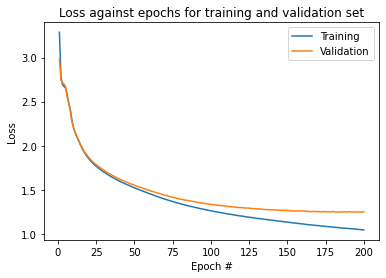

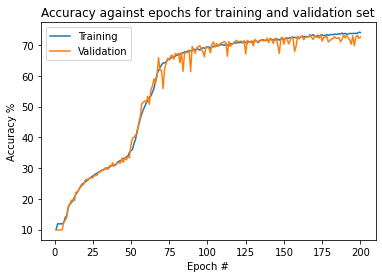

Testing.......
Test_Loss: 1.247 Test_Accuracy: 0.701 

In [ ]:
## Final Model ##

# From grid search findings
#The highest validation accuracy 0.440508633852005 on the RNN was achieved with: number_epochs = 200, number_layers = 2 , hidden_dim = 200, learning_rate = 0.005
#The highest validation accuracy 0.7175295352935791 on the GRU was achieved with: number_epochs = 200, number_layers = 2 , hidden_dim = 100, learning_rate = 0.01
#The highest validation accuracy 0.7211626172065735 on the LSTM was achieved with: number_epochs = 200, number_layers = 2 , hidden_dim = 150, learning_rate = 0.001
# Clearly LSTM is the best model out of Vanilla, GRU andl LSTM as it produces the highest accuracy 72.1% > 71.8% > 44.1% ( LSTM>GRU >> RNN)
# Paramters we consider for the final model are: sequence_length = 79, epochs = 200 , bacth_size = 128, learning_rate = 0.001, hidden_dim = 150 , num_layers = 2 .

model = LSTMModel(input_size = dictionary_size, output_size = dictionary_size, hidden_dim= 150, n_layers=2).to(device) # set up model and forward prop with specified layer size
optim(lr = 0.001) # set up optimiser with specified learning rate

# train the model

print('Training and validation.......')
valid_accuracy, train_l, train_acc, valid_l, valid_acc, epoch_num = train_valid(n_epochs=200) # train model with specified epochs

# plotting loss per epoch for the training and validation sets

plt.plot(epoch_num, train_l, label = 'Training')
plt.plot(epoch_num, valid_l, label = 'Validation')
plt.title('Loss against epochs for training and validation set')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting accuracy per epoch for the training and validation sets

plt.plot(epoch_num, train_acc, Label = 'Training')
plt.plot(epoch_num, valid_acc, label = 'Validation')
plt.title('Accuracy against epochs for training and validation set')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

# test the model

print('Testing.......')
test()


In [ ]:
# We only care about the last output
# We pad or clip the test sequence, then let it complete the sentence
# sequence length is 282,
# we supply example sentence
# "I am an idiot, what are you going "
# we want to complete such sentence
# pad it to 282 or clip it
# then predict, shift and predict, until the max number of time is done.
# We set limit to maybe 50 operations and see the results.

test_sequence = ["Absolutely rubbish and utter filth. Worst film ever. "," Heartwarming, funny and beatifill. She was amazing.   ", "This movie is really good, have you seen it? ", "I love action, comedy and the rocky series", "The best movie of all time is forestgump"]

test_sequencexs = paddingAndClipping(test_sequence) # pad up to 80 characters

test_sequencexs = [item[1:] for item in test_sequencexs]
# converting characters in the sequences to sequences of integers by mapping them using dictionaries
for i in range(len(test_sequencexs)):
  test_sequencexs[i] = [char_to_integer[character] if character in char_to_integer else (dictionary_size-1)
    for character in test_sequencexs[i]]
test_sequencexs = one_hot_encoding(test_sequencexs, dictionary_size, sequence_length)


n_predictions = 150 # 100 characters in the future. Need more to predict a sentnace thats why we predict 50.

for prediction in range(n_predictions):
# evaluation mode
  model.eval()
  output, hidden = model(test_sequencexs.view(5 , sequence_length, dictionary_size)) # so coming in of length maxlength -1 inputs in

  # get last item from output, which is our next character prediction
  # the predicted class is a index
  predicted_character = torch.max(output.view(-1,sequence_length,dictionary_size)[:,-1,:],1).indices

  
  test_sequencexs = torch.cat((test_sequencexs[:,1:,:], one_hot_encoding(torch.tensor(predicted_character.view(-1,1), dtype=torch.int32).tolist(), dictionary_size, 1)), 1)

#convert one hot encoded test sequence back to normal sequence
# use argmax or max to find.

output_sequences = []
for sequence in test_sequencexs:
  characterIntegerList = torch.max(sequence,1).indices
  tempString = ""
  for integer in characterIntegerList:
    for key, value in char_to_integer.items(): # for name, age in dictionary.iteritems(): (for Python 2.x)
      if value == integer:
        tempString+=key
  output_sequences.append(tempString)

for i in range(len(test_sequence)):
    print("Input sentence: ", test_sequence[i])
    print("Model prediction: ", output_sequences[i])
    print('-------------------------------------------------------------------------------------------------------------------------------------------------')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Input sentence:  ***************************Absolutely rubbish and utter filth. Worst film ever. 
Model prediction:   a movie that starts off as a star ... a compelling ... an action film ... it '
-------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence:  ************************* Heartwarming, funny and beatifill. She was amazing.   
Model prediction:   is a bit ... a compelling , but it 's a star of the performance ... it was n't
-------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence:  ***********************************This movie is really good, have you seen it? 
Model prediction:  ld be a the film 's story ... it would be ... but it 's a standard and some of 
---------------------------------------------------------------------------------------------------------------------

## Assignment 2.4: Bag of vectors ##

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-13 11:02:36--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  82.6MB/s    in 17s     

2020-12-13 11:02:53 (92.9 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
import gensim
import numpy as np
from sklearn.preprocessing import OneHotEncoder
all_stopwords = gensim.parsing.preprocessing.STOPWORDS

from gensim.models import KeyedVectors
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True, limit = 100000)

In [ ]:
def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, ys

x_train, y_train = loadsst("/content/train.txt")
x_val, y_val = loadsst("/content/dev.txt")
x_test, y_test = loadsst("/content/test.txt")
len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)

(8544, 8544, 1101, 1101, 2210, 2210)

In [ ]:
X_train = x_train
X_val = x_val
X_test = x_test

In [ ]:
vocab = []
for sentence in X_train:
    vocab += sentence
    
vocab = set(vocab)

In [ ]:
word2vec.wv.vocab.get("UNK").index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


98307

In [ ]:
# build vocab to integer mapping
from collections import Counter
counts = Counter(vocab)

X_train_ints = [] 
for sentence in X_train:     
    X_train_ints.append([word2vec.wv.vocab.get(word).index if word in word2vec.wv.vocab else 98307 for word in sentence])

X_val_ints = [] 
for sentence in X_val:     
    X_val_ints.append([word2vec.wv.vocab.get(word).index if word in word2vec.wv.vocab else 98307 for word in sentence])

X_test_ints = [] 
for sentence in X_test:     
    X_test_ints.append([word2vec.wv.vocab.get(word).index if word in word2vec.wv.vocab else 98307 for word in sentence])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


Zero-length sentences: 0
Maximum sentence length: 52
Number of reviews before removing outliers:  8544
Number of train reviews after removing outliers:  8544
Number of reviews before removing outliers:  1101
Number of val reviews after removing outliers:  1101


In [ ]:
train_sentence_lengths = []
for sentence in X_train:
    train_sentence_lengths.append(len(sentence))

val_sentence_lengths = []
for sentence in X_val:
    val_sentence_lengths.append(len(sentence))

test_sentence_lengths = []
for sentence in X_test:
    test_sentence_lengths.append(len(sentence))

In [ ]:
def pad_features(X_ints, seq_length):
    # getting the correct rows x cols shape
    features = np.zeros((len(X_ints), seq_length), dtype=int)

    # for each review, I grab that review and
    for i, row in enumerate(X_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    return features
# Test your implementation!

seq_length = max(sentence_lens)

features_train = pad_features(X_train_ints, seq_length=seq_length)
features_val = pad_features(X_val_ints, seq_length=seq_length)
features_test = pad_features(X_test_ints, seq_length=seq_length)

print(features_train.shape)
print(features_val.shape)
print(features_test.shape)

(8544, 52)
(1101, 52)
(2210, 52)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [ ]:
weights = torch.FloatTensor(word2vec.wv.vectors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
training_features_tensor = torch.tensor(features_train, dtype=torch.float)
training_sentence_lengths = torch.tensor(train_sentence_lengths, dtype=torch.float)
training_labels_tensor = torch.tensor(y_train, dtype=torch.float)
val_features_tensor = torch.tensor(features_val, dtype=torch.float)
val_sentence_lengths = torch.tensor(val_sentence_lengths, dtype=torch.float)
val_labels_tensor = torch.tensor(y_val, dtype=torch.float)
test_features_tensor = torch.tensor(features_test, dtype=torch.float)
test_sentence_lengths = torch.tensor(test_sentence_lengths, dtype=torch.float)
test_labels_tensor = torch.tensor(y_test, dtype=torch.float)

3.4.1 - Checking implementation

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 1024  
hidden_layer_1 = 128
hidden_layer_2 = 64
output_size = 5
emb_dim = 300

In [ ]:
trainset = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor, training_sentence_lengths)
valset = torch.utils.data.TensorDataset(val_features_tensor, val_labels_tensor, val_sentence_lengths)
testset = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor, test_sentence_lengths)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_features_tensor.shape[0], shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_features_tensor.shape[0], shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
    def __init__(self, pre_trained_embeddings, sentence_length):
      super(Net, self).__init__()
      self.sentence_length = sentence_length
      self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
      self.fc1 = nn.Linear(emb_dim, hidden_layer_1) 
      self.drop_layer = nn.Dropout(p= 0.2)
      self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
      self.drop_layer_2 = nn.Dropout(p= 0.2)
      self.fc3 = nn.Linear(hidden_layer_2, output_size)

    def forward(self, x, sentence_length):
      input = x.type(torch.LongTensor)
      sentence_length = sentence_length.to(dtype=torch.long)
      embeds = self.embeddings(input) # [batch_size, max_length, emb] 
      final = torch.mean(embeds, dim = 1)
  
      x = self.fc1(final)
      x = self.drop_layer(x)
      x = torch.tanh(x)
      x = self.fc2(x)
      x = self.drop_layer_2(x)
      x = torch.tanh(x)
      x = self.fc3(x)
      return x



In [ ]:
net = Net(weights, train_sentence_lengths)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    num_of_batches = 0 
    for i, data in enumerate(trainloader, 0):
        inputs, labels, lengths = data
        optimizer.zero_grad()
        logits = net(inputs, lengths)
        targets = labels.type(torch.LongTensor)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_of_batches +=1
       

    train_logits = net(training_features_tensor, training_sentence_lengths)
    _, train_predictions = torch.max(train_logits.data, 1)
    train_correct_predictions = (train_predictions.int() == training_labels_tensor.int()).sum().numpy()
    train_length = training_labels_tensor.size()[0]
    train_accuracy = train_correct_predictions/train_length
    
    train_costs.append(running_loss/num_of_batches)
    train_accuracies.append(train_accuracy)
    
    if epoch%10 == 0:
      print("Epoch: %d/%d, Loss: %.6f, Accuracy: %.6f"%(epoch + 1,EPOCHS, running_loss/num_of_batches, train_accuracy) )

Epoch: 1/100, Loss: 1.582056, Accuracy: 0.272355
Epoch: 11/100, Loss: 1.397918, Accuracy: 0.394078
Epoch: 21/100, Loss: 1.314592, Accuracy: 0.428605
Epoch: 31/100, Loss: 1.284669, Accuracy: 0.437383
Epoch: 41/100, Loss: 1.275137, Accuracy: 0.449555
Epoch: 51/100, Loss: 1.264821, Accuracy: 0.452715
Epoch: 61/100, Loss: 1.255668, Accuracy: 0.457982
Epoch: 71/100, Loss: 1.251084, Accuracy: 0.461493
Epoch: 81/100, Loss: 1.242309, Accuracy: 0.465005
Epoch: 91/100, Loss: 1.253777, Accuracy: 0.457865


In [ ]:
import matplotlib.pyplot as plt

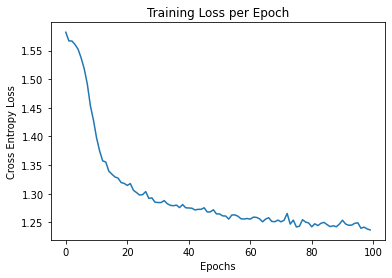

In [ ]:
plt.plot(range(len(train_costs)), train_costs)
plt.title("Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

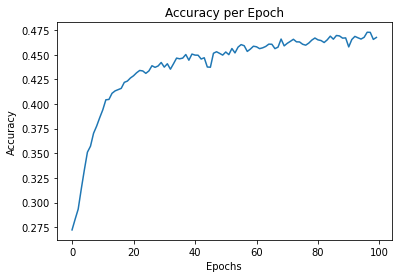

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

3.4.2 - Exploring model variants

In [ ]:
# first max and min pooling will be explored:
class NetMax(nn.Module):
    def __init__(self, pre_trained_embeddings, sentence_length):
      super(NetMax, self).__init__()
      self.sentence_length = sentence_length
      self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
      self.fc1 = nn.Linear(emb_dim, hidden_layer_1) 
      self.drop_layer = nn.Dropout(p= 0.2)
      self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
      self.drop_layer_2 = nn.Dropout(p= 0.2)
      self.fc3 = nn.Linear(hidden_layer_2, output_size)

    def forward(self, x, sentence_length):
      input = x.type(torch.LongTensor)
      sentence_length = sentence_length.to(dtype=torch.long)
      embeds = self.embeddings(input) # [batch_size, max_length, emb] 
      _, final = torch.max(embeds, dim=1)
      final = final.type(torch.float)
      
      x = self.fc1(final)
      x = self.drop_layer(x)
      x = torch.tanh(x)
      x = self.fc2(x)
      x = self.drop_layer_2(x)
      x = torch.tanh(x)
      x = self.fc3(x)
      return x

In [ ]:
net = NetMax(weights, train_sentence_lengths)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []
val_costs = []
val_accuracies = []
test_costs = []
test_accuracies = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    num_of_batches = 0 
    for i, data in enumerate(trainloader, 0):
        inputs, labels, lengths = data
        optimizer.zero_grad()
        logits = net(inputs, lengths)
        targets = labels.type(torch.LongTensor)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_of_batches +=1
        

    train_logits = net(training_features_tensor, training_sentence_lengths)
    _, train_predictions = torch.max(train_logits.data, 1)
    train_correct_predictions = (train_predictions.int() == training_labels_tensor.int()).sum().numpy()
    train_length = training_labels_tensor.size()[0]
    train_accuracy = train_correct_predictions/train_length

    val_logits = net(val_features_tensor, val_sentence_lengths)
    val_loss = criterion(val_logits, val_labels_tensor.type(torch.LongTensor))
    _, val_predictions = torch.max(val_logits.data, 1) 
    val_correct_predictions = (val_predictions.int() == val_labels_tensor.int()).sum().numpy()
    val_length = val_labels_tensor.size()[0]
    val_accuracy = val_correct_predictions/val_length

    test_logits = net(test_features_tensor, test_sentence_lengths)
    test_loss = criterion(test_logits, test_labels_tensor.type(torch.LongTensor))
    _, test_predictions = torch.max(test_logits.data, 1) 
    test_correct_predictions = (test_predictions.int() == test_labels_tensor.int()).sum().numpy()
    test_length = test_labels_tensor.size()[0]
    test_accuracy = test_correct_predictions/test_length
    if epoch%10 == 0:
        print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f'%(epoch + 1,EPOCHS, running_loss / num_of_batches, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy))

    train_costs.append(running_loss/num_of_batches)
    train_accuracies.append(train_accuracy)
    val_costs.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_costs.append(test_loss)
    test_accuracies.append(test_accuracy)

print("Best train accuracy: ", max(train_accuracies), 'at epoch: ', np.argmax(train_accuracies), "Best val accuracy: ", max(val_accuracies), 'at epoch: ', np.argmax(val_accuracies), "Best test accuracy: ", max(test_accuracies), 'at epoch: ', np.argmax(test_accuracies))

Epoch: 1/100, train loss: 1.584, train acc: 0.268, val loss: 1.578, val acc: 0.258, test loss: 1.587, test acc: 0.254
Epoch: 11/100, train loss: 1.573, train acc: 0.267, val loss: 1.579, val acc: 0.255, test loss: 1.583, test acc: 0.242
Epoch: 21/100, train loss: 1.568, train acc: 0.261, val loss: 1.578, val acc: 0.261, test loss: 1.582, test acc: 0.252
Epoch: 31/100, train loss: 1.571, train acc: 0.275, val loss: 1.571, val acc: 0.260, test loss: 1.580, test acc: 0.243
Epoch: 41/100, train loss: 1.568, train acc: 0.264, val loss: 1.573, val acc: 0.262, test loss: 1.580, test acc: 0.258
Epoch: 51/100, train loss: 1.570, train acc: 0.272, val loss: 1.574, val acc: 0.253, test loss: 1.585, test acc: 0.231
Epoch: 61/100, train loss: 1.571, train acc: 0.265, val loss: 1.572, val acc: 0.241, test loss: 1.580, test acc: 0.247
Epoch: 71/100, train loss: 1.569, train acc: 0.273, val loss: 1.575, val acc: 0.254, test loss: 1.581, test acc: 0.245
Epoch: 81/100, train loss: 1.571, train acc: 0.27

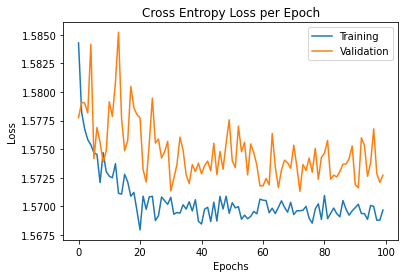

In [ ]:
plt.plot(range(len(train_costs)), train_costs, label='Training')
plt.plot(range(len(val_costs)), val_costs, label='Validation')
plt.title("Cross Entropy Loss per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

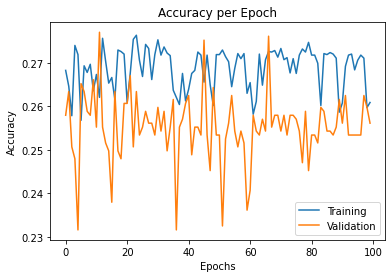

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training')
plt.plot(range(len(val_accuracies)), val_accuracies,  label='Validation')
plt.title("Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
class NetMin(nn.Module):
    def __init__(self, pre_trained_embeddings, sentence_length):
      super(NetMin, self).__init__()
      self.sentence_length = sentence_length
      self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
      self.fc1 = nn.Linear(emb_dim, hidden_layer_1) 
      self.drop_layer = nn.Dropout(p= 0.2)
      self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
      self.drop_layer_2 = nn.Dropout(p= 0.2)
      self.fc3 = nn.Linear(hidden_layer_2, output_size)

    def forward(self, x, sentence_length):
      input = x.type(torch.LongTensor)
      sentence_length = sentence_length.to(dtype=torch.long)
      embeds = self.embeddings(input) # [batch_size, max_length, emb] 
      _, final = torch.min(embeds, dim=1)
      final = final.type(torch.float)
      
      x = self.fc1(final)
      x = self.drop_layer(x)
      x = torch.tanh(x)
      x = self.fc2(x)
      x = self.drop_layer_2(x)
      x = torch.tanh(x)
      x = self.fc3(x)
      return x

In [ ]:
net = NetMin(weights, train_sentence_lengths)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []
val_costs = []
val_accuracies = []
test_costs = []
test_accuracies = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    num_of_batches = 0 
    for i, data in enumerate(trainloader, 0):
        inputs, labels, lengths = data
        optimizer.zero_grad()
        logits = net(inputs, lengths)
        targets = labels.type(torch.LongTensor)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_of_batches +=1
        

    train_logits = net(training_features_tensor, training_sentence_lengths)
    _, train_predictions = torch.max(train_logits.data, 1)
    train_correct_predictions = (train_predictions.int() == training_labels_tensor.int()).sum().numpy()
    train_length = training_labels_tensor.size()[0]
    train_accuracy = train_correct_predictions/train_length

    val_logits = net(val_features_tensor, val_sentence_lengths)
    val_loss = criterion(val_logits, val_labels_tensor.type(torch.LongTensor))
    _, val_predictions = torch.max(val_logits.data, 1) 
    val_correct_predictions = (val_predictions.int() == val_labels_tensor.int()).sum().numpy()
    val_length = val_labels_tensor.size()[0]
    val_accuracy = val_correct_predictions/val_length

    test_logits = net(test_features_tensor, test_sentence_lengths)
    test_loss = criterion(test_logits, test_labels_tensor.type(torch.LongTensor))
    _, test_predictions = torch.max(test_logits.data, 1) 
    test_correct_predictions = (test_predictions.int() == test_labels_tensor.int()).sum().numpy()
    test_length = test_labels_tensor.size()[0]
    test_accuracy = test_correct_predictions/test_length
    if epoch%10 == 0:
        print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f'%(epoch + 1,EPOCHS, running_loss / num_of_batches, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy))

    train_costs.append(running_loss/num_of_batches)
    train_accuracies.append(train_accuracy)
    val_costs.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_costs.append(test_loss)
    test_accuracies.append(test_accuracy)

print("Best train accuracy: ", max(train_accuracies), 'at epoch: ', np.argmax(train_accuracies), "Best val accuracy: ", max(val_accuracies), 'at epoch: ', np.argmax(val_accuracies), "Best test accuracy: ", max(test_accuracies), 'at epoch: ', np.argmax(test_accuracies))

Epoch: 1/100, train loss: 1.586, train acc: 0.270, val loss: 1.588, val acc: 0.263, test loss: 1.589, test acc: 0.252
Epoch: 11/100, train loss: 1.572, train acc: 0.270, val loss: 1.576, val acc: 0.250, test loss: 1.596, test acc: 0.227
Epoch: 21/100, train loss: 1.571, train acc: 0.272, val loss: 1.579, val acc: 0.254, test loss: 1.586, test acc: 0.233
Epoch: 31/100, train loss: 1.571, train acc: 0.271, val loss: 1.571, val acc: 0.250, test loss: 1.584, test acc: 0.241
Epoch: 41/100, train loss: 1.570, train acc: 0.272, val loss: 1.577, val acc: 0.253, test loss: 1.587, test acc: 0.231
Epoch: 51/100, train loss: 1.569, train acc: 0.270, val loss: 1.573, val acc: 0.266, test loss: 1.584, test acc: 0.229
Epoch: 61/100, train loss: 1.569, train acc: 0.272, val loss: 1.572, val acc: 0.253, test loss: 1.584, test acc: 0.231
Epoch: 71/100, train loss: 1.569, train acc: 0.271, val loss: 1.575, val acc: 0.254, test loss: 1.585, test acc: 0.234
Epoch: 81/100, train loss: 1.569, train acc: 0.26

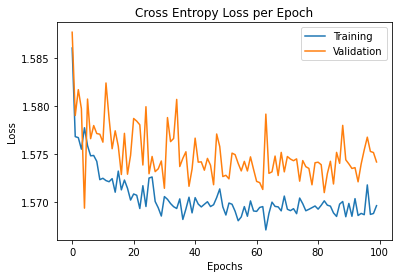

In [ ]:
plt.plot(range(len(train_costs)), train_costs, label='Training')
plt.plot(range(len(val_costs)), val_costs, label='Validation')
plt.title("Cross Entropy Loss per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

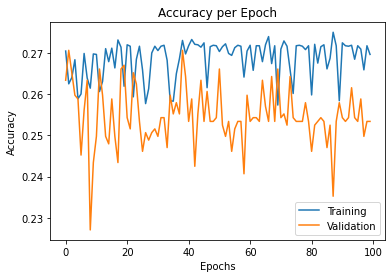

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training')
plt.plot(range(len(val_accuracies)), val_accuracies,  label='Validation')
plt.title("Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# the focus will be on optimising parameters for the mean pooling model

class Optimisation_Net(nn.Module):
    def __init__(self, pre_trained_embeddings, sentence_length, num_nodes):
      super(Optimisation_Net, self).__init__()
      self.sentence_length = sentence_length
      self.num_nodes = num_nodes

      self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
      self.fc1 = nn.Linear(emb_dim, self.num_nodes) 
      self.drop_layer = nn.Dropout(p= 0.2)
      self.fc2 = nn.Linear(num_nodes, num_nodes)
      self.drop_layer_2 = nn.Dropout(p= 0.2)
      self.fc3 = nn.Linear(num_nodes, output_size)

    def forward(self, x, sentence_length):
      input = x.type(torch.LongTensor)
      sentence_length = sentence_length.to(dtype=torch.long)
      embeds = self.embeddings(input) # [batch_size, max_length, emb] 
      final = torch.mean(embeds, dim = 1)
      
      x = self.fc1(final)
      x = self.drop_layer(x)
      x = torch.tanh(x)
      x = self.fc2(x)
      x = self.drop_layer_2(x)
      x = torch.tanh(x)
      x = self.fc3(x)
      return x



In [ ]:
batch_sizes = [256, 512, 1024]
nodes = [64, 128, 256]

for batch in batch_sizes:
    for num_nodes in nodes:

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)

        net = Optimisation_Net(weights, train_sentence_lengths, num_nodes)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

        train_costs = []
        train_accuracies = []
        val_costs = []
        val_accuracies = []

        for epoch in range(EPOCHS):
            running_loss = 0.0
            num_of_batches = 0 
            for i, data in enumerate(trainloader, 0):
                inputs, labels, lengths = data
                optimizer.zero_grad()
                logits = net(inputs, lengths)
                targets = labels.type(torch.LongTensor)
                loss = criterion(logits, targets)
                loss.backward()
                optimizer.step()
                  
                running_loss += loss.item()
                num_of_batches +=1

            train_logits = net(training_features_tensor, training_sentence_lengths)
            _, train_predictions = torch.max(train_logits.data, 1)
            train_correct_predictions = (train_predictions.int() == training_labels_tensor.int()).sum().numpy()
            train_length = training_labels_tensor.size()[0]
            train_accuracy = train_correct_predictions/train_length

            val_logits = net(val_features_tensor, val_sentence_lengths)
            val_loss = criterion(val_logits, val_labels_tensor.type(torch.LongTensor))
            _, val_predictions = torch.max(val_logits.data, 1) 
            val_correct_predictions = (val_predictions.int() == val_labels_tensor.int()).sum().numpy()
            val_length = val_labels_tensor.size()[0]
            val_accuracy = val_correct_predictions/val_length

              
            train_costs.append(running_loss/num_of_batches)
            train_accuracies.append(train_accuracy)
            val_costs.append(val_loss.item())
            val_accuracies.append(val_accuracy)

        print("Model: Batch Size: ", batch, " No. Nodes: ", num_nodes , " Best train accuracy: ", max(train_accuracies), 'at epoch: ', np.argmax(train_accuracies), "Best val accuracy: ", max(val_accuracies), 'at epoch: ', np.argmax(val_accuracies))

Model: Batch Size:  256  No. Nodes:  64  Best train accuracy:  0.47869850187265917 at epoch:  96 Best val accuracy:  0.4405086285195277 at epoch:  51
Model: Batch Size:  256  No. Nodes:  128  Best train accuracy:  0.4830290262172285 at epoch:  70 Best val accuracy:  0.4368755676657584 at epoch:  88
Model: Batch Size:  256  No. Nodes:  256  Best train accuracy:  0.4827949438202247 at epoch:  99 Best val accuracy:  0.44504995458673935 at epoch:  26
Model: Batch Size:  512  No. Nodes:  64  Best train accuracy:  0.47542134831460675 at epoch:  99 Best val accuracy:  0.4396003633060854 at epoch:  49
Model: Batch Size:  512  No. Nodes:  128  Best train accuracy:  0.4803370786516854 at epoch:  98 Best val accuracy:  0.4359673024523161 at epoch:  50
Model: Batch Size:  512  No. Nodes:  256  Best train accuracy:  0.4824438202247191 at epoch:  99 Best val accuracy:  0.4396003633060854 at epoch:  33
Model: Batch Size:  1024  No. Nodes:  64  Best train accuracy:  0.46266385767790263 at epoch:  94 B

3.4.3 - Training final model to convergence

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 256 
hidden_layer_1 = 256 
hidden_layer_2 = 256
output_size = 5
emb_dim = 300

In [ ]:
trainset = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor, training_sentence_lengths)
valset = torch.utils.data.TensorDataset(val_features_tensor, val_labels_tensor, val_sentence_lengths)
testset = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor, test_sentence_lengths)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_features_tensor.shape[0], shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_features_tensor.shape[0], shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
    def __init__(self, pre_trained_embeddings, sentence_length):
      super(Net, self).__init__()
      self.sentence_length = sentence_length
      self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
      self.fc1 = nn.Linear(emb_dim, hidden_layer_1) 
      self.drop_layer = nn.Dropout(p= 0.2)
      self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
      self.drop_layer_2 = nn.Dropout(p= 0.2)
      self.fc3 = nn.Linear(hidden_layer_2, output_size)

    def forward(self, x, sentence_length):
      input = x.type(torch.LongTensor)
      sentence_length = sentence_length.to(dtype=torch.long)
      embeds = self.embeddings(input) # [batch_size, max_length, emb] 
      final = torch.mean(embeds, dim = 1)
  
      x = self.fc1(final)
      x = self.drop_layer(x)
      x = torch.tanh(x)
      x = self.fc2(x)
      x = self.drop_layer_2(x)
      x = torch.tanh(x)
      x = self.fc3(x)
      return x

In [ ]:
net = Net(weights, train_sentence_lengths)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []
val_costs = []
val_accuracies = []
test_costs = []
test_accuracies = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    num_of_batches = 0 
    for i, data in enumerate(trainloader, 0):
        inputs, labels, lengths = data
        optimizer.zero_grad()
        logits = net(inputs, lengths)
        targets = labels.type(torch.LongTensor)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_of_batches +=1
       

    train_logits = net(training_features_tensor, training_sentence_lengths)
    _, train_predictions = torch.max(train_logits.data, 1)
    train_correct_predictions = (train_predictions.int() == training_labels_tensor.int()).sum().numpy()
    train_length = training_labels_tensor.size()[0]
    train_accuracy = train_correct_predictions/train_length

    val_logits = net(val_features_tensor, val_sentence_lengths)
    val_loss = criterion(val_logits, val_labels_tensor.type(torch.LongTensor))
    _, val_predictions = torch.max(val_logits.data, 1) 
    val_correct_predictions = (val_predictions.int() == val_labels_tensor.int()).sum().numpy()
    val_length = val_labels_tensor.size()[0]
    val_accuracy = val_correct_predictions/val_length

    test_logits = net(test_features_tensor, test_sentence_lengths)
    test_loss = criterion(test_logits, test_labels_tensor.type(torch.LongTensor))
    _, test_predictions = torch.max(test_logits.data, 1) 
    test_correct_predictions = (test_predictions.int() == test_labels_tensor.int()).sum().numpy()
    test_length = test_labels_tensor.size()[0]
    test_accuracy = test_correct_predictions/test_length
    if epoch%5 == 0:
        print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f'%(epoch + 1,EPOCHS, running_loss / num_of_batches, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy))

    train_costs.append(running_loss/num_of_batches)
    train_accuracies.append(train_accuracy)
    val_costs.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_costs.append(test_loss)
    test_accuracies.append(test_accuracy)

print("Best train accuracy: ", max(train_accuracies), 'at epoch: ', np.argmax(train_accuracies), "Best val accuracy: ", max(val_accuracies), 'at epoch: ', np.argmax(val_accuracies), "Best test accuracy: ", max(test_accuracies), 'at epoch: ', np.argmax(test_accuracies))

Epoch: 1/30, train loss: 1.571, train acc: 0.292, val loss: 1.559, val acc: 0.282, test loss: 1.569, test acc: 0.268
Epoch: 6/30, train loss: 1.319, train acc: 0.424, val loss: 1.345, val acc: 0.408, test loss: 1.336, test acc: 0.413
Epoch: 11/30, train loss: 1.289, train acc: 0.444, val loss: 1.337, val acc: 0.427, test loss: 1.315, test acc: 0.433
Epoch: 16/30, train loss: 1.266, train acc: 0.450, val loss: 1.345, val acc: 0.413, test loss: 1.328, test acc: 0.427
Epoch: 21/30, train loss: 1.266, train acc: 0.455, val loss: 1.358, val acc: 0.424, test loss: 1.330, test acc: 0.428
Epoch: 26/30, train loss: 1.255, train acc: 0.469, val loss: 1.344, val acc: 0.425, test loss: 1.310, test acc: 0.440
Best train accuracy:  0.46851591760299627 at epoch:  25 Best val accuracy:  0.4332425068119891 at epoch:  17 Best test accuracy:  0.4425339366515837 at epoch:  26


3.4.4 - Plot of the loss on the training and validation set per epoch of training

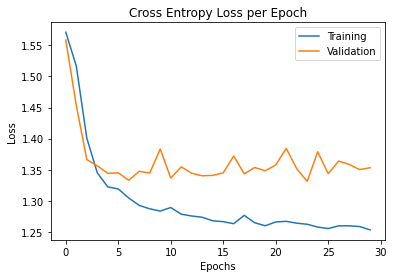

In [ ]:
plt.plot(range(len(train_costs)), train_costs, label='Training')
plt.plot(range(len(val_costs)), val_costs, label='Validation')
plt.title("Cross Entropy Loss per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

3.4.5 - Final accuracy on the training, validation and test set. 

In [ ]:
print("Final Train Accuracy: %.6f, Final Validation Accuracy: %.6f, Test Validation Test: %.6f"%(train_accuracies[-1], val_accuracies[-1], test_accuracies[-1]))

Final Train Accuracy: 0.462781, Final Validation Accuracy: 0.433243, Test Validation Test: 0.423529


3.4.6 - Providing a selection of classification decisions of the final model for 5 opinionated sentences from movie reviews. 

In [ ]:
movie_reviews = [["Heartwarming , funny , and  beautifullyanimated , Toy  Story 4 manages  the  unlikely  feat ofextending  , and  perhaps  concluding  , a practically  perfectanimated  saga."],
                 ["Murder  Mystery  reunites  Jennifer  Aniston  and  AdamSandler  for a lightweight  comedy  that’s contentto  settle  for  merely  mediocre."],
                 ["While  watching  these  two  actors  share  the  screen  asan  estranged  father  and son is  compelling , that’s really  all The  Judge  has  going  for it. Outsideof  Duvall  and RDJ , the  script  is super  formulaic."],
                 ["Sometimes  you see  failed  films  and think , well ,they  tried  for  this or that  but  couldn ’t pull itoff. After  seeing  Ben  Stiller ’s version  of thevenerable  James  Thurber  story , I don’t know  whatthe  film  was  trying  for."],
                 ["A film  for kids , students , stoners , anyone  whoenjoys a break  from  reality."],
                 ["The  movie  is  alright."]]
                 
# note that the "movie is alright" is a test, it is not an actual film review it was for us to determine if the model could classify it as "neutral"

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
X_test_movie = []
for  sentence  in  movie_reviews:
  X_test_movie.append(nltk.word_tokenize(sentence [0]))
  
X_test_movie_ints = []
test_movie_sentence_lengths = []
for  sentence  in  X_test_movie:
  X_test_movie_ints.append ([word2vec.wv.vocab.get(word).index if word in word2vec.wv.vocab else 98307 for word in sentence])
  test_movie_sentence_lengths.append(len(sentence))
  
test_movie_seq_length = max(test_movie_sentence_lengths)
features_test_movie = pad_features(X_test_movie_ints , test_movie_seq_length)

test_movie_features_tensor = torch.tensor(features_test_movie , dtype=torch.float).to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
idx_to_sent = {
    0: "Extremely Negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Extremely Positive"}

In [ ]:
movie_logits = net(test_movie_features_tensor, torch.tensor(test_movie_sentence_lengths)).to(device)
_, movie_predictions = torch.max(movie_logits.data, dim=1)
for i in range(len(movie_reviews)):
  print("Review: ", movie_reviews[i][0])
  print("Sentiment:  ", idx_to_sent[movie_predictions[i].item()])
  print("Class: ", movie_predictions[i].item())
  print("--------------------------------------------------------------")

Review:  Heartwarming , funny , and  beautifullyanimated , Toy  Story 4 manages  the  unlikely  feat ofextending  , and  perhaps  concluding  , a practically  perfectanimated  saga.
Sentiment:   Extremely Positive
Class:  4
--------------------------------------------------------------
Review:  Murder  Mystery  reunites  Jennifer  Aniston  and  AdamSandler  for a lightweight  comedy  that’s contentto  settle  for  merely  mediocre.
Sentiment:   Neutral
Class:  2
--------------------------------------------------------------
Review:  While  watching  these  two  actors  share  the  screen  asan  estranged  father  and son is  compelling , that’s really  all The  Judge  has  going  for it. Outsideof  Duvall  and RDJ , the  script  is super  formulaic.
Sentiment:   Positive
Class:  3
--------------------------------------------------------------
Review:  Sometimes  you see  failed  films  and think , well ,they  tried  for  this or that  but  couldn ’t pull itoff. After  seeing  Ben  Stil

## Assignment 2.5: Sequence encoding ##

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-12 22:52:28--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  86.0MB/s    in 19s     

2020-12-12 22:52:47 (83.8 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
import gensim
import numpy as np
from sklearn.preprocessing import OneHotEncoder
all_stopwords = gensim.parsing.preprocessing.STOPWORDS

from gensim.models import KeyedVectors
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True, limit = 100000)

In [ ]:
def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, ys

X_train, y_train = loadsst("/content/train.txt")
X_val, y_val = loadsst("/content/dev.txt")
X_test, y_test = loadsst("/content/test.txt")
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(8544, 8544, 1101, 1101, 2210, 2210)

In [ ]:
# build vocab
vocab = []
for sentence in X_train:
    vocab += sentence
vocab = list(set(vocab))
vocab.insert(0, "UNK")
print("Number of unique vocabs: ", len(vocab))

# # build vocab to integer mapping
from collections import Counter
counts = Counter(vocab)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 0)}


def convert_words_to_idx(X):  
    X_ints = [] 
    X_lengths = []
    for sentence in X:     
        X_ints.append([vocab_to_int["UNK"] if word not in vocab_to_int else vocab_to_int[word] for word in sentence])
        X_lengths.append(len(sentence))
    return X_ints, X_lengths


X_train_ints, train_sentence_lengths = convert_words_to_idx(X_train)
X_val_ints, val_sentence_lengths = convert_words_to_idx(X_val)
X_test_ints, test_sentence_lengths = convert_words_to_idx(X_test)


Number of unique vocabs:  18279


In [ ]:
def vocab_embeddings(vocab):
    k = 0
    embedding = np.zeros((len(vocab),300))
    for word in vocab:
        if word in word2vec.vocab:
            embedding[k] = word2vec[word]
        else:
            embedding[k] = word2vec['UNK']
        k = k + 1
    return embedding

In [ ]:
embedding_matrix = vocab_embeddings(vocab)
embedding_matrix.shape

(18279, 300)

In [ ]:
for i in range(len(embedding_matrix)):
    if vocab[i] in word2vec.vocab:
        if (word2vec[vocab[i]] != embedding_matrix[i]).all():
            print(vocab[i], "wrong")
    else:
        if (word2vec["UNK"] != embedding_matrix[i]).all():
            print(vocab[i], "wrong")

In [ ]:
del word2vec

In [ ]:
def left_pad(X_ints, seq_length):

    features = np.zeros((len(X_ints), seq_length), dtype=int)
    for i, row in enumerate(X_ints):
        features[i, -len(row):] = np.array(row)
    return features

def right_pad(X_ints, seq_length):

    features = np.zeros((len(X_ints), seq_length), dtype=int)
    for i, row in enumerate(X_ints):
        features[i, :len(row)] = np.array(row)
    return features



seq_length = max(train_sentence_lengths)

features_train = left_pad(X_train_ints, seq_length=seq_length)
features_val = left_pad(X_val_ints, seq_length=seq_length)

test_seq_length = max(test_sentence_lengths)
features_test = left_pad(X_test_ints, seq_length=test_seq_length)

print(features_train.shape)
print(features_val.shape)
print(features_test.shape)

## test statements - do not change - ##
assert len(features_train)==len(X_train), "Your features should have as many rows as reviews."
assert len(features_train[0])==seq_length, "Each feature row should contain seq_length values."
assert len(features_val)==len(X_val), "Your features should have as many rows as reviews."
assert len(features_val[0])==seq_length, "Each feature row should contain seq_length values."
assert len(features_test)==len(X_test), "Your features should have as many rows as reviews."
assert len(features_test[0]==test_seq_length), "Each feature row should contain seq_length values."

(8544, 52)
(1101, 52)
(2210, 56)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU IS AVAILABLE :D') 
else:  
    device = torch.device("cpu") 
    print('GPU not available')

GPU IS AVAILABLE :D


In [ ]:
pretrained_embeddings = torch.FloatTensor(embedding_matrix)
print(pretrained_embeddings.shape)

torch.Size([18279, 300])


In [ ]:
training_features_tensor = torch.tensor(features_train, dtype=torch.float).to(device)
training_sentence_lengths = torch.tensor(train_sentence_lengths, dtype=torch.float).to(device)
training_labels_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
val_features_tensor = torch.tensor(features_val, dtype=torch.float).to(device)
val_sentence_lengths = torch.tensor(val_sentence_lengths, dtype=torch.float).to(device)
val_labels_tensor = torch.tensor(y_val, dtype=torch.float).to(device)
test_features_tensor = torch.tensor(features_test, dtype=torch.float).to(device)
test_sentence_lengths = torch.tensor(test_sentence_lengths, dtype=torch.float).to(device)
test_labels_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

LEARNING_RATE = 0.0001
EPOCHS = 20
BATCH_SIZE = 128
hidden_layer_1 = 128
#hidden_layer_2 = 64
emb_dim = 300
hidden_dim = 400
output_size = 5

In [ ]:
trainset = torch.utils.data.TensorDataset(training_features_tensor, training_labels_tensor, training_sentence_lengths)
valset = torch.utils.data.TensorDataset(val_features_tensor, val_labels_tensor, val_sentence_lengths)
testset = torch.utils.data.TensorDataset(test_features_tensor, test_labels_tensor, test_sentence_lengths)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class RNN(nn.Module):
    def __init__(self, pre_trained_embeddings, emb_dim, hidden_dim):
        super(RNN, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
        self.rnn = nn.RNN(emb_dim, hidden_dim, 1, batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim, hidden_layer_1) 
        self.drop_layer = nn.Dropout(p= 0.3)
        # self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # self.drop_layer_2 = nn.Dropout(p= 0.2)
        self.fc3 = nn.Linear(hidden_layer_1, output_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        # hidden = torch.zeros(1, batch_size, self.hidden_dim)
        return hidden

    def forward(self, x, batch_size, x_lens):
        input = x.long().type(torch.LongTensor)
        lengths = x_lens.long().type(torch.LongTensor)
        hidden = self.init_hidden(batch_size)
        cell = self.init_hidden(batch_size)
        embeds = self.embeddings(input) # (b_z, m_l, emb_dim)
        output, hidden = self.rnn(embeds)
        final = output[:,-1,:]
        
        x = torch.tanh(self.fc1(final))
        x = self.drop_layer(x) # if relu, apply dropout before activation
        # x = torch.tanh(self.fc2(x))
        # x = self.drop_layer_2(x)
        x = self.fc3(x)
        return x

In [ ]:
class LSTM(nn.Module):
    def __init__(self, pre_trained_embeddings, emb_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, 1, batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim, hidden_layer_1) 
        self.drop_layer = nn.Dropout(p= 0.3)
        # self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # self.drop_layer_2 = nn.Dropout(p= 0.2)
        self.fc3 = nn.Linear(hidden_layer_1, output_size)

    # def init_hidden(self, batch_size):
        # hidden = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        # hidden = torch.zeros(1, batch_size, self.hidden_dim)
        # return hidden

    def forward(self, x, batch_size, x_lens):
        input = x.long().type(torch.LongTensor)
        lengths = x_lens.long().type(torch.LongTensor)
        # hidden = self.init_hidden(batch_size)
        # cell = self.init_hidden(batch_size)
        embeds = self.embeddings(input) # (b_z, m_l, emb_dim)
        output, hidden = self.lstm(embeds)
        final = output[:,-1,:]
        
        x = torch.tanh(self.fc1(final))
        x = self.drop_layer(x) # if relu, apply dropout before activation
        # x = torch.tanh(self.fc2(x))
        # x = self.drop_layer_2(x)
        x = self.fc3(x)
        return x

In [ ]:
class GRU(nn.Module):
    def __init__(self, pre_trained_embeddings, emb_dim, hidden_dim):
        super(GRU, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=True)
        self.gru = nn.GRU(emb_dim, hidden_dim, 1, batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim, hidden_layer_1) 
        self.drop_layer = nn.Dropout(p= 0.3)
        # self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # self.drop_layer_2 = nn.Dropout(p= 0.2)
        self.fc3 = nn.Linear(hidden_layer_1, output_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        # hidden = torch.zeros(1, batch_size, self.hidden_dim)
        return hidden

    def forward(self, x, batch_size, x_lens):
        input = x.long().type(torch.LongTensor)
        lengths = x_lens.long().type(torch.LongTensor)
        hidden = self.init_hidden(batch_size)
        cell = self.init_hidden(batch_size)
        embeds = self.embeddings(input) # (b_z, m_l, emb_dim)
        output, hidden = self.gru(embeds)
        final = output[:,-1,:]
        
        x = torch.tanh(self.fc1(final))
        x = self.drop_layer(x) # if relu, apply dropout before activation
        # x = torch.tanh(self.fc2(x))
        # x = self.drop_layer_2(x)
        x = self.fc3(x)
        return x

In [ ]:
## training and validation function ##

def train_val():

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

  train_costs = []
  train_accuracies = []
  val_costs = []
  val_accuracies = []
  num_epochs = []

  patience = 10
  steps = 0

  for epoch in range(EPOCHS):
      
      num_of_batches = 0 
      val_batch = 0
      running_train_loss = 0.0
      running_train_acc = 0.0
      running_val_loss = 0.0
      running_val_acc = 0.0

      for i, (inputs, labels, lengths) in enumerate(trainloader, 0):
          optimizer.zero_grad()
          logits = net(inputs, BATCH_SIZE, lengths).to(device)
          targets = labels.type(torch.LongTensor).to(device)
          loss = criterion(logits, targets)
          loss.backward()
          optimizer.step()

          num_of_batches += 1
          running_train_loss += loss.item()

          _, train_predictions = torch.max(logits.data, 1)
          train_correct_predictions = (train_predictions.int() == labels.int()).sum()
          train_length = labels.size()[0]
          running_train_acc += train_correct_predictions/train_length

      for i, (inputs, labels, lengths) in enumerate(valloader, 0):
          val_logits = net(inputs, BATCH_SIZE, lengths).to(device)
          val_loss = criterion(val_logits, labels.type(torch.LongTensor).to(device))
          running_val_loss += val_loss.item()

          _, val_predictions = torch.max(val_logits.data, 1)
          val_correct_predictions = (val_predictions.int() == labels.int()).sum()
          val_length = labels.size()[0]
          running_val_acc += val_correct_predictions/val_length
          val_batch += 1


      train_costs.append(running_train_loss / num_of_batches)
      train_accuracies.append(running_train_acc / num_of_batches)
      val_costs.append(running_val_loss / val_batch)
      val_accuracies.append(running_val_acc / val_batch)
      num_epochs.append(epoch)

      if epoch > 0 and val_costs[epoch] > val_costs[epoch-1]:
          steps += 1
      else:
          steps = 0

      if steps == patience:
          break

      if epoch % 1 == 0:
          print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f val loss: %.3f, val acc: %.3f, step:  %.3f'%(epoch + 1,EPOCHS, running_train_loss / num_of_batches, running_train_acc / num_of_batches, running_val_loss / val_batch, running_val_acc / val_batch, int(steps)))
  
  print('Final Train loss: %.3f -- Validation Loss: %.3f'%(train_costs[-1],val_costs[-1]))
  print("Final Train accuracy: %.3f -- Validation Accuracy: %.3f"%(train_accuracies[-1].item(), val_accuracies[-1].item()))

  return train_costs, train_accuracies, val_costs, val_accuracies, num_epochs

In [ ]:
## "vanilla" RNN variant of the model ##

net = RNN(pretrained_embeddings, emb_dim, hidden_dim) # specify model variant
train_costs, train_accuracies, val_costs, val_accuracies, num_epochs = train_val() # train the model and evaluate on the validation set

Epoch: 1/20, train loss: 1.574, train acc: 0.270 val loss: 1.570, val acc: 0.250, step:  0.000
Epoch: 2/20, train loss: 1.545, train acc: 0.317 val loss: 1.592, val acc: 0.269, step:  1.000
Epoch: 3/20, train loss: 1.468, train acc: 0.356 val loss: 1.401, val acc: 0.380, step:  0.000
Epoch: 4/20, train loss: 1.429, train acc: 0.378 val loss: 1.495, val acc: 0.334, step:  1.000
Epoch: 5/20, train loss: 1.394, train acc: 0.384 val loss: 1.389, val acc: 0.386, step:  0.000
Epoch: 6/20, train loss: 1.359, train acc: 0.409 val loss: 1.376, val acc: 0.397, step:  0.000
Epoch: 7/20, train loss: 1.359, train acc: 0.398 val loss: 1.391, val acc: 0.381, step:  1.000
Epoch: 8/20, train loss: 1.344, train acc: 0.411 val loss: 1.365, val acc: 0.385, step:  0.000
Epoch: 9/20, train loss: 1.329, train acc: 0.416 val loss: 1.356, val acc: 0.400, step:  0.000
Epoch: 10/20, train loss: 1.323, train acc: 0.422 val loss: 1.362, val acc: 0.399, step:  1.000
Epoch: 11/20, train loss: 1.300, train acc: 0.426

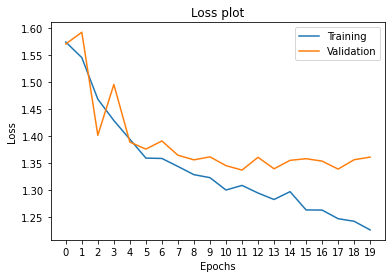

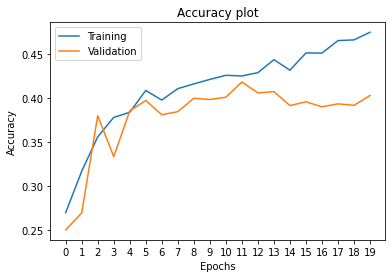

In [ ]:
## plots for "vanilla" RNN ##

# plot loss for train and validation set

plt.plot(num_epochs, train_costs, label = 'Training')
plt.plot(num_epochs, val_costs, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(num_epochs)
plt.legend()
plt.title('Loss plot')
plt.show()

# plot accuracy for train and validation set

plt.plot(num_epochs, train_accuracies, label = 'Training')
plt.plot(num_epochs, val_accuracies, label = 'Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(num_epochs)
plt.title('Accuracy plot')
plt.show()

In [ ]:
## LSTM RNN variant of the model ##

net = LSTM(pretrained_embeddings, emb_dim, hidden_dim) # specify model variant
train_costs, train_accuracies, val_costs, val_accuracies, num_epochs = train_val() # train the model and evaluate on the validation set

Epoch: 1/20, train loss: 1.576, train acc: 0.266 val loss: 1.572, val acc: 0.269, step:  0.000
Epoch: 2/20, train loss: 1.566, train acc: 0.280 val loss: 1.560, val acc: 0.331, step:  0.000
Epoch: 3/20, train loss: 1.561, train acc: 0.300 val loss: 1.550, val acc: 0.317, step:  0.000
Epoch: 4/20, train loss: 1.532, train acc: 0.328 val loss: 1.501, val acc: 0.336, step:  0.000
Epoch: 5/20, train loss: 1.459, train acc: 0.367 val loss: 1.430, val acc: 0.372, step:  0.000
Epoch: 6/20, train loss: 1.423, train acc: 0.380 val loss: 1.404, val acc: 0.386, step:  0.000
Epoch: 7/20, train loss: 1.390, train acc: 0.391 val loss: 1.381, val acc: 0.376, step:  0.000
Epoch: 8/20, train loss: 1.360, train acc: 0.398 val loss: 1.370, val acc: 0.387, step:  0.000
Epoch: 9/20, train loss: 1.344, train acc: 0.409 val loss: 1.353, val acc: 0.398, step:  0.000
Epoch: 10/20, train loss: 1.333, train acc: 0.411 val loss: 1.391, val acc: 0.397, step:  1.000
Epoch: 11/20, train loss: 1.326, train acc: 0.413

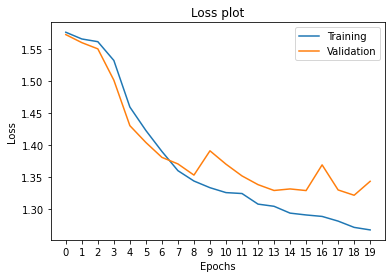

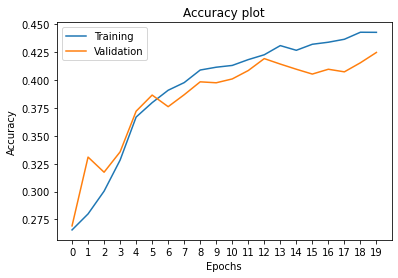

In [ ]:
## plots for LSTM variant ##

# plot loss for train and validation set

plt.plot(num_epochs, train_costs, label = 'Training')
plt.plot(num_epochs, val_costs, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(num_epochs)
plt.legend()
plt.title('Loss plot')
plt.show()

# plot accuracy for train and validation set

plt.plot(num_epochs, train_accuracies, label = 'Training')
plt.plot(num_epochs, val_accuracies, label = 'Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(num_epochs)
plt.title('Accuracy plot')
plt.show()

In [ ]:
## GRU RNN variant of the model ##

net = GRU(pretrained_embeddings, emb_dim, hidden_dim) # specify model variant
train_costs, train_accuracies, val_costs, val_accuracies, num_epochs = train_val() # train the model and evaluate on the validation set

Epoch: 1/20, train loss: 1.577, train acc: 0.273 val loss: 1.572, val acc: 0.265, step:  0.000
Epoch: 2/20, train loss: 1.558, train acc: 0.298 val loss: 1.537, val acc: 0.311, step:  0.000
Epoch: 3/20, train loss: 1.516, train acc: 0.327 val loss: 1.485, val acc: 0.348, step:  0.000
Epoch: 4/20, train loss: 1.432, train acc: 0.373 val loss: 1.402, val acc: 0.379, step:  0.000
Epoch: 5/20, train loss: 1.383, train acc: 0.396 val loss: 1.378, val acc: 0.376, step:  0.000
Epoch: 6/20, train loss: 1.352, train acc: 0.407 val loss: 1.359, val acc: 0.400, step:  0.000
Epoch: 7/20, train loss: 1.333, train acc: 0.413 val loss: 1.347, val acc: 0.408, step:  0.000
Epoch: 8/20, train loss: 1.324, train acc: 0.419 val loss: 1.363, val acc: 0.412, step:  1.000
Epoch: 9/20, train loss: 1.318, train acc: 0.423 val loss: 1.346, val acc: 0.399, step:  0.000
Epoch: 10/20, train loss: 1.303, train acc: 0.429 val loss: 1.333, val acc: 0.427, step:  0.000
Epoch: 11/20, train loss: 1.296, train acc: 0.431

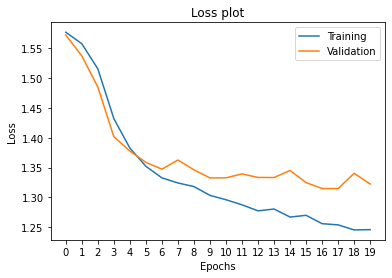

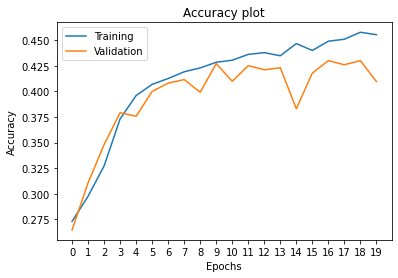

In [ ]:
## plots for GRU variant ##

# plot loss for train and validation set

plt.plot(num_epochs, train_costs, label = 'Training')
plt.plot(num_epochs, val_costs, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(num_epochs)
plt.legend()
plt.title('Loss plot')
plt.show()

# plot accuracy for train and validation set

plt.plot(num_epochs, train_accuracies, label = 'Training')
plt.plot(num_epochs, val_accuracies, label = 'Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(num_epochs)
plt.title('Accuracy plot')
plt.show()

In [ ]:
## Updating the embeddings: testing if updating the embeddings performs better to keeping them fixed during training ##

In [ ]:
class RNN(nn.Module):
    def __init__(self, pre_trained_embeddings, emb_dim, hidden_dim):
        super(RNN, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=False)
        self.rnn = nn.RNN(emb_dim, hidden_dim, 1, batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim, hidden_layer_1) 
        self.drop_layer = nn.Dropout(p= 0.3)
        # self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # self.drop_layer_2 = nn.Dropout(p= 0.2)
        self.fc3 = nn.Linear(hidden_layer_1, output_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        # hidden = torch.zeros(1, batch_size, self.hidden_dim)
        return hidden

    def forward(self, x, batch_size, x_lens):
        input = x.long().type(torch.LongTensor)
        lengths = x_lens.long().type(torch.LongTensor)
        hidden = self.init_hidden(batch_size)
        cell = self.init_hidden(batch_size)
        embeds = self.embeddings(input) # (b_z, m_l, emb_dim)
        output, hidden = self.rnn(embeds)
        final = output[:,-1,:]
        
        x = torch.tanh(self.fc1(final))
        x = self.drop_layer(x) # if relu, apply dropout before activation
        # x = torch.tanh(self.fc2(x))
        # x = self.drop_layer_2(x)
        x = self.fc3(x)
        return x

In [ ]:
net = RNN(pretrained_embeddings, emb_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []
val_costs = []
val_accuracies = []

patience = 5
steps = 0

for epoch in range(EPOCHS):
    
    num_of_batches = 0 
    val_batch = 0
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0

    for i, (inputs, labels, lengths) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        logits = net(inputs, BATCH_SIZE, lengths).to(device)
        targets = labels.type(torch.LongTensor).to(device)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        num_of_batches += 1
        running_train_loss += loss.item()

        _, train_predictions = torch.max(logits.data, 1)
        train_correct_predictions = (train_predictions.int() == labels.int()).sum()
        train_length = labels.size()[0]
        running_train_acc += train_correct_predictions/train_length

    for i, (inputs, labels, lengths) in enumerate(valloader, 0):
        val_logits = net(inputs, BATCH_SIZE, lengths).to(device)
        val_loss = criterion(val_logits, labels.type(torch.LongTensor).to(device))
        running_val_loss += val_loss.item()

        _, val_predictions = torch.max(val_logits.data, 1)
        val_correct_predictions = (val_predictions.int() == labels.int()).sum()
        val_length = labels.size()[0]
        running_val_acc += val_correct_predictions/val_length
        val_batch += 1


    train_costs.append(running_train_loss / num_of_batches)
    train_accuracies.append(running_train_acc / num_of_batches)
    val_costs.append(running_val_loss / val_batch)
    val_accuracies.append(running_val_acc / val_batch)
    if epoch > 0 and val_costs[epoch] > val_costs[epoch-1]:
        steps += 1
    else:
        steps = 0

    if steps == patience:
        break

    #if epoch % 1 == 0:
    print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f val loss: %.3f, val acc: %.3f, step:  %.3f'%(epoch + 1,EPOCHS, running_train_loss / num_of_batches, running_train_acc / num_of_batches, running_val_loss / val_batch, running_val_acc / val_batch, int(steps)))

print("Best val accuracy: ", max(val_accuracies), 'at epoch: ', np.argmax(val_accuracies))

Epoch: 1/20, train loss: 1.539, train acc: 0.313 val loss: 1.517, val acc: 0.336, step:  0.000
Epoch: 2/20, train loss: 1.269, train acc: 0.460 val loss: 1.398, val acc: 0.399, step:  0.000
Epoch: 3/20, train loss: 1.008, train acc: 0.560 val loss: 1.501, val acc: 0.354, step:  1.000
Epoch: 4/20, train loss: 0.829, train acc: 0.665 val loss: 1.624, val acc: 0.383, step:  2.000
Epoch: 5/20, train loss: 0.653, train acc: 0.780 val loss: 1.782, val acc: 0.380, step:  3.000
Epoch: 6/20, train loss: 0.531, train acc: 0.841 val loss: 1.979, val acc: 0.376, step:  4.000
Best val accuracy:  tensor(0.3989, device='cuda:0') at epoch:  1


In [ ]:
class LSTM(nn.Module):
    def __init__(self, pre_trained_embeddings, emb_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=False)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, 1, batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim, hidden_layer_1) 
        self.drop_layer = nn.Dropout(p= 0.3)
        # self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # self.drop_layer_2 = nn.Dropout(p= 0.2)
        self.fc3 = nn.Linear(hidden_layer_1, output_size)

    # def init_hidden(self, batch_size):
        # hidden = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        # hidden = torch.zeros(1, batch_size, self.hidden_dim)
        # return hidden

    def forward(self, x, batch_size, x_lens):
        input = x.long().type(torch.LongTensor)
        lengths = x_lens.long().type(torch.LongTensor)
        # hidden = self.init_hidden(batch_size)
        # cell = self.init_hidden(batch_size)
        embeds = self.embeddings(input) # (b_z, m_l, emb_dim)
        output, hidden = self.lstm(embeds)
        final = output[:,-1,:]
        
        x = torch.tanh(self.fc1(final))
        x = self.drop_layer(x) # if relu, apply dropout before activation
        # x = torch.tanh(self.fc2(x))
        # x = self.drop_layer_2(x)
        x = self.fc3(x)
        return x

In [ ]:
net = LSTM(pretrained_embeddings, emb_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []
val_costs = []
val_accuracies = []

patience = 5
steps = 0

for epoch in range(EPOCHS):
    
    num_of_batches = 0 
    val_batch = 0
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0

    for i, (inputs, labels, lengths) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        logits = net(inputs, BATCH_SIZE, lengths).to(device)
        targets = labels.type(torch.LongTensor).to(device)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        num_of_batches += 1
        running_train_loss += loss.item()

        _, train_predictions = torch.max(logits.data, 1)
        train_correct_predictions = (train_predictions.int() == labels.int()).sum()
        train_length = labels.size()[0]
        running_train_acc += train_correct_predictions/train_length

    for i, (inputs, labels, lengths) in enumerate(valloader, 0):
        val_logits = net(inputs, BATCH_SIZE, lengths).to(device)
        val_loss = criterion(val_logits, labels.type(torch.LongTensor).to(device))
        running_val_loss += val_loss.item()

        _, val_predictions = torch.max(val_logits.data, 1)
        val_correct_predictions = (val_predictions.int() == labels.int()).sum()
        val_length = labels.size()[0]
        running_val_acc += val_correct_predictions/val_length
        val_batch += 1

    # if epoch%10 == 0:
    
    #print('Epoch: %d/%d, train loss: %.3f'%(epoch + 1,EPOCHS, running_loss / num_of_batches))

    train_costs.append(running_train_loss / num_of_batches)
    train_accuracies.append(running_train_acc / num_of_batches)
    val_costs.append(running_val_loss / val_batch)
    val_accuracies.append(running_val_acc / val_batch)
    if epoch > 0 and val_costs[epoch] > val_costs[epoch-1]:
        steps += 1
    else:
        steps = 0

    if steps == patience:
        break

   # if epoch % 2 == 0:
    print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f val loss: %.3f, val acc: %.3f, step:  %.3f'%(epoch + 1,EPOCHS, running_train_loss / num_of_batches, running_train_acc / num_of_batches, running_val_loss / val_batch, running_val_acc / val_batch, int(steps)))

print("Best val accuracy: ", max(val_accuracies), 'at epoch: ', np.argmax(val_accuracies))

Epoch: 1/20, train loss: 1.572, train acc: 0.292 val loss: 1.563, val acc: 0.295, step:  0.000
Epoch: 2/20, train loss: 1.448, train acc: 0.397 val loss: 1.413, val acc: 0.382, step:  0.000
Epoch: 3/20, train loss: 1.033, train acc: 0.563 val loss: 1.481, val acc: 0.386, step:  1.000
Epoch: 4/20, train loss: 0.879, train acc: 0.650 val loss: 1.601, val acc: 0.374, step:  2.000
Epoch: 5/20, train loss: 0.631, train acc: 0.790 val loss: 1.787, val acc: 0.387, step:  3.000
Epoch: 6/20, train loss: 0.502, train acc: 0.849 val loss: 2.099, val acc: 0.360, step:  4.000
Best val accuracy:  tensor(0.3867, device='cuda:0') at epoch:  4


In [ ]:
class GRU(nn.Module):
    def __init__(self, pre_trained_embeddings, emb_dim, hidden_dim):
        super(GRU, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=False)
        self.gru = nn.GRU(emb_dim, hidden_dim, 1, batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim, hidden_layer_1) 
        self.drop_layer = nn.Dropout(p= 0.3)
        # self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # self.drop_layer_2 = nn.Dropout(p= 0.2)
        self.fc3 = nn.Linear(hidden_layer_1, output_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        # hidden = torch.zeros(1, batch_size, self.hidden_dim)
        return hidden

    def forward(self, x, batch_size, x_lens):
        input = x.long().type(torch.LongTensor)
        lengths = x_lens.long().type(torch.LongTensor)
        hidden = self.init_hidden(batch_size)
        cell = self.init_hidden(batch_size)
        embeds = self.embeddings(input) # (b_z, m_l, emb_dim)
        output, hidden = self.gru(embeds)
        final = output[:,-1,:]
        
        x = torch.tanh(self.fc1(final))
        x = self.drop_layer(x) # if relu, apply dropout before activation
        # x = torch.tanh(self.fc2(x))
        # x = self.drop_layer_2(x)
        x = self.fc3(x)
        return x

In [ ]:
net = GRU(pretrained_embeddings, emb_dim, hidden_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_costs = []
train_accuracies = []
val_costs = []
val_accuracies = []

patience = 5
steps = 0

for epoch in range(EPOCHS):
    
    num_of_batches = 0 
    val_batch = 0
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0

    for i, (inputs, labels, lengths) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        logits = net(inputs, BATCH_SIZE, lengths).to(device)
        targets = labels.type(torch.LongTensor).to(device)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        num_of_batches += 1
        running_train_loss += loss.item()

        _, train_predictions = torch.max(logits.data, 1)
        train_correct_predictions = (train_predictions.int() == labels.int()).sum()
        train_length = labels.size()[0]
        running_train_acc += train_correct_predictions/train_length

    for i, (inputs, labels, lengths) in enumerate(valloader, 0):
        val_logits = net(inputs, BATCH_SIZE, lengths).to(device)
        val_loss = criterion(val_logits, labels.type(torch.LongTensor).to(device))
        running_val_loss += val_loss.item()

        _, val_predictions = torch.max(val_logits.data, 1)
        val_correct_predictions = (val_predictions.int() == labels.int()).sum()
        val_length = labels.size()[0]
        running_val_acc += val_correct_predictions/val_length
        val_batch += 1

    # if epoch%10 == 0:
    
    #print('Epoch: %d/%d, train loss: %.3f'%(epoch + 1,EPOCHS, running_loss / num_of_batches))

    train_costs.append(running_train_loss / num_of_batches)
    train_accuracies.append(running_train_acc / num_of_batches)
    val_costs.append(running_val_loss / val_batch)
    val_accuracies.append(running_val_acc / val_batch)
    if epoch > 0 and val_costs[epoch] > val_costs[epoch-1]:
        steps += 1
    else:
        steps = 0

    if steps == patience:
        break

  #  if epoch % 2 == 0:
    print('Epoch: %d/%d, train loss: %.3f, train acc: %.3f val loss: %.3f, val acc: %.3f, step:  %.3f'%(epoch + 1,EPOCHS, running_train_loss / num_of_batches, running_train_acc / num_of_batches, running_val_loss / val_batch, running_val_acc / val_batch, int(steps)))


Epoch: 1/20, train loss: 1.560, train acc: 0.300 val loss: 1.550, val acc: 0.297, step:  0.000
Epoch: 2/20, train loss: 1.323, train acc: 0.465 val loss: 1.598, val acc: 0.305, step:  1.000
Epoch: 3/20, train loss: 1.077, train acc: 0.552 val loss: 1.438, val acc: 0.394, step:  0.000
Epoch: 4/20, train loss: 0.784, train acc: 0.702 val loss: 1.613, val acc: 0.393, step:  1.000
Epoch: 5/20, train loss: 0.590, train acc: 0.823 val loss: 1.887, val acc: 0.382, step:  2.000
Epoch: 6/20, train loss: 0.455, train acc: 0.869 val loss: 2.178, val acc: 0.369, step:  3.000
Epoch: 7/20, train loss: 0.376, train acc: 0.889 val loss: 2.291, val acc: 0.381, step:  4.000


In [ ]:
## training the optimal model variant and testing ##

In [ ]:
## test function ##

def test():
  test_batch = 0
  running_test_acc = 0
  running_test_loss = 0

  for i, (inputs, labels, lengths) in enumerate(testloader, 0):
          test_logits = net(inputs, BATCH_SIZE, lengths).to(device)
          test_loss = criterion(test_logits, labels.type(torch.LongTensor).to(device))
          running_test_loss += test_loss.item()

          _, test_predictions = torch.max(test_logits.data, 1)
          test_correct_predictions = (test_predictions.int() == labels.int()).sum()
          test_length = labels.size()[0]
          running_test_acc += test_correct_predictions/test_length
          test_batch += 1

  print('Final Accuracy on the test set: ', running_test_acc/test_batch)

In [ ]:
## final model ##

# in the model variant evaluation above LSTM performed the best with a validation accuracy of 42.5%, this model variant will be used as the final model

net = LSTM(pretrained_embeddings, emb_dim, hidden_dim) # specify model variant

print('Training...')

train_costs, train_accuracies, val_costs, val_accuracies, num_epochs = train_val() # train the model and evaluate on the validation set

print('Testing...')

criterion = nn.CrossEntropyLoss()
test()

Training...
Epoch: 1/20, train loss: 1.575, train acc: 0.263 val loss: 1.574, val acc: 0.254, step:  0.000
Epoch: 2/20, train loss: 1.565, train acc: 0.289 val loss: 1.563, val acc: 0.278, step:  0.000
Epoch: 3/20, train loss: 1.527, train acc: 0.323 val loss: 1.487, val acc: 0.353, step:  0.000
Epoch: 4/20, train loss: 1.449, train acc: 0.369 val loss: 1.407, val acc: 0.371, step:  0.000
Epoch: 5/20, train loss: 1.390, train acc: 0.393 val loss: 1.382, val acc: 0.382, step:  0.000
Epoch: 6/20, train loss: 1.361, train acc: 0.399 val loss: 1.358, val acc: 0.394, step:  0.000
Epoch: 7/20, train loss: 1.344, train acc: 0.408 val loss: 1.345, val acc: 0.415, step:  0.000
Epoch: 8/20, train loss: 1.325, train acc: 0.415 val loss: 1.352, val acc: 0.400, step:  1.000
Epoch: 9/20, train loss: 1.314, train acc: 0.419 val loss: 1.334, val acc: 0.409, step:  0.000
Epoch: 10/20, train loss: 1.309, train acc: 0.422 val loss: 1.343, val acc: 0.398, step:  1.000
Epoch: 11/20, train loss: 1.297, trai

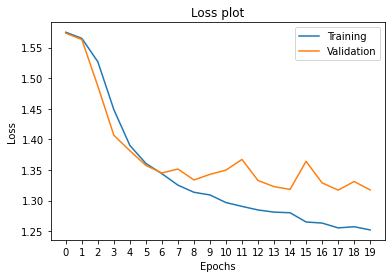

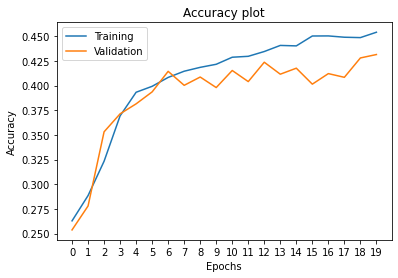

In [ ]:
## plots for final model ##

# plot loss for train and validation set

plt.plot(num_epochs, train_costs, label = 'Training')
plt.plot(num_epochs, val_costs, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(num_epochs)
plt.legend()
plt.title('Loss plot')
plt.show()

# plot accuracy for train and validation set

plt.plot(num_epochs, train_accuracies, label = 'Training')
plt.plot(num_epochs, val_accuracies, label = 'Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(num_epochs)
plt.title('Accuracy plot')
plt.show()

In [ ]:
!pip install nltk
nltk.download('punkt')
import nltk
movie_reviews = [['Heartwarming, funny, and beautifully animated, Toy Story 4 manages the unlikely feat of extending , and perhaps concluding , a practically perfect animated saga.'],
          ["Murder Mystery reunites Jennifer Aniston and Adam Sandler for a lightweight comedy that's content to settle for merely mediocre."],
          ["While watching these two actors share the screen as an estranged father and son is compelling, that's really all The Judge has going for it. Outside of Duvall and RDJ, the script is super formulaic."],
          ["A film for kids, students, stoners, anyone who enjoys a break from reality."], 
          ["It's artless and repulsive. I've seen many other films that are grotesque or disturbing and even plain disgusting but when the whole film is this way just for that sole purpose it becomes worthless."]]
          

X_test = []
for sentence in movie_reviews:
    X_test.append(nltk.word_tokenize(sentence[0]))

X_test_ints = []
test_sentence_lengths = []
for sentence in X_test:     
    X_test_ints.append([vocab_to_int["UNK"] if word not in vocab_to_int else vocab_to_int[word] for word in sentence])
    test_sentence_lengths.append(len(sentence))

test_seq_length = max(test_sentence_lengths)
features_test = left_pad(X_test_ints, seq_length=test_seq_length)
assert len(features_test[0]==test_seq_length)

test_features_tensor = torch.tensor(features_test, dtype=torch.float).to(device)


test_batch = 0
running_test_acc = 0
running_test_loss = 0

net.eval()

idx_to_sent = { 
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'}

test_logits = net(test_features_tensor, 5, torch.Tensor(test_sentence_lengths)).to(device)
_, test_predictions = torch.max(test_logits.data, 1)
for i in range(len(movie_reviews)):
    print('Review: ', movie_reviews[i][0])
    print('Sentiment: ',idx_to_sent[test_predictions[i].item()])
    print('Class:', test_predictions[i].item())
    print('--------------------------------------------------')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Review:  Heartwarming, funny, and beautifully animated, Toy Story 4 manages the unlikely feat of extending , and perhaps concluding , a practically perfect animated saga.
Sentiment:  Extremely Positive
Class: 4
--------------------------------------------------
Review:  Murder Mystery reunites Jennifer Aniston and Adam Sandler for a lightweight comedy that's content to settle for merely mediocre.
Sentiment:  Negative
Class: 1
--------------------------------------------------
Review:  While watching these two actors share the screen as an estranged father and son is compelling, that's really all The Judge has going for it. Outside of Duvall and RDJ, the script is super formulaic.
Sentiment:  Negative
Class: 1
--------------------------------------------------
Review:  A film for kids, students, stoners, anyone who enjoys a break from reality.
Sentiment:  Positive
Class: 3
----